# DCBHs from HR of PBHs

In this notebook, we calculate the Hawking Radiation properties of Primordial Black Holes and examine their potential to contribute to the _Direct Collapse Black Hole_ scenario for the formation of SMBHs in early galaxies.

__Main idea__: The presence of SMBHs with masses in the region of $10^9 M_\odot$ at the first billion years of the universe requires the growth or formation of massive BHs at high redshifts ($z>10$). There are various channels for the production of massive BHs. In this project, as PBHs evaporate due to Hawking Radiation, they provide radiation that can suppress $H_2$ formation, leading atomic cooling halos to avoid collapse and fragmentation to smaller stars.

__Paper__: For more details, we refer to our paper [[2411.09081](https://arxiv.org/abs/2411.09081)].

### Table of contents <a name="toc"></a>

**PBHs properties**
1. [Hawking Temperature with BH mass (includes constraints from $T_{\rm crit}$)](#HR_Mbh)
2. [Blackbody Spectra (includes Greybody factors check)](#Blackbody)
3. [Connection of energy and frequency/wavelength of photons (includes massive particles check)](#Photons)
4. [Age with redshift (includes constraints from $z_{\rm evap}$)](#time_redshift)
5. [Formation of BHs](#BH_formation)
6. [Evaporation of BHs](#BH_evaporation)

**LW radiation constraints**

7. [DCBHs requirements (includes X-ray feedback)](#DCBHs_requirements)
8. [PBHs mass functions](#PBH_masses)
9. [Appendix](#appendix)

__Importing modules and constants__

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from support import *

--------------------------------

# Hawking Temperature with BH mass <a name="HR_Mbh"></a>

The temperature of a BH as a function of mass, in the case of Schwarzschild BHs, is given by:

$$
T = \frac{\hbar c^3}{8 \pi k_B G} \frac{1}{M_{\rm BH}}
$$

Return to TOC [here](#toc).

Sanity check: $T \sim 10^{-7}$ K, for $M=M_\odot$.

In [3]:
print(f"The T_HR for 1 Mo BH is: {Hawking_temperature_from_mass(1)} K")
print(f"The T_HR for 1 Mo BH [in gr] is: {Hawking_temperature_from_mass(M_SOLAR_2_GRAMS, units='cgs')} K")
print()
print(f"The BH mass [Mo] for 1e-7 K is: {BH_mass_from_Hawking_temperature(6.17e-8)} Mo")
print(f"The BH mass [gr] for 1e-7 K is: {BH_mass_from_Hawking_temperature(6.17e-8, units='cgs')} gr")

The T_HR for 1 Mo BH is: 6.165330002985011e-08 K
The T_HR for 1 Mo BH [in gr] is: 6.165330002985011e-08 K

The BH mass [Mo] for 1e-7 K is: 0.9992431123152365 Mo
The BH mass [gr] for 1e-7 K is: 1.987494550395006e+33 gr


To calculate a lower-limit, critical temperature for our case, we need photons of energy $E_\gamma>2.0$ eV. For details, see Section 3 [here](#Photons).

In [4]:
nu_Hm, lamda_Hm = photons_from_energy(2.0)

## Wien's law to find temperature of BB spectrum, at peak frequency
T_Hm = nu_Hm/b_wien_freq

In [5]:
BH_masses = np.logspace(15, 37, 200)
HR_temperatures = Hawking_temperature_from_mass(BH_masses, units='cgs')

In [6]:
example_masses = {"Asteroid": 1e-14, "Sun": 1, r"LIGO [$30\ M_\odot$]": 30}  # Test masses in solar units

example_T = np.zeros(len(example_masses))

for i, items in enumerate(list(example_masses)):
    example_T[i] = Hawking_temperature_from_mass(example_masses[items], units='solar')

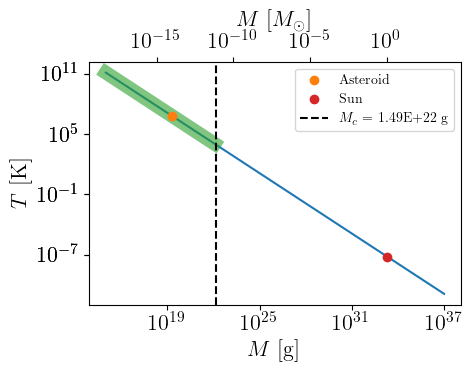

In [7]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(1, 1, 1)
ax2=fig.add_subplot(111, label="2", frame_on=False)

colours = list(mcolors.TABLEAU_COLORS.keys())[1::2]

ax1.loglog(BH_masses, HR_temperatures)
ax1.loglog(BH_masses[HR_temperatures>T_Hm], HR_temperatures[HR_temperatures>T_Hm], ls='-',\
           c='tab:green', lw=10, alpha=0.6)

for i, items in enumerate(list(example_masses)[:-1]):
    ax1.scatter(example_masses[items]*M_SOLAR_2_GRAMS, example_T[i], label=f"{items}",\
                zorder=100, c=colours[i])

mass_critical_T = BH_mass_from_Hawking_temperature(T_Hm, units='cgs')
ax1.axvline(x=mass_critical_T, ls='--', c='black', label = fr'$M_c$ = {(mass_critical_T):.2E} g')
ax1.set_xlabel(r"$M$ [g]")
ax1.set_ylabel(r"$T$ [K]")
ax1.legend(fontsize=10)

ax2.loglog(BH_masses/M_SOLAR_2_GRAMS, HR_temperatures, ls=' ')
ax2.xaxis.tick_top()
ax2.set_xlabel(r"$M\ [M_\odot]$")
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x')

plt.tight_layout()
# plt.show()
plt.savefig("Figures/temperature_masses.png", bbox_inches="tight")

For the critical temperature:

In [8]:
print(f"The BH mass [Mo] for ~8e3 K is: {BH_mass_from_Hawking_temperature(T_Hm)} Mo")
print(f"The BH mass [gr] for ~8e3 K is: {BH_mass_from_Hawking_temperature(T_Hm, units='cgs')} gr")

The BH mass [Mo] for ~8e3 K is: 7.495560281480144e-12 Mo
The BH mass [gr] for ~8e3 K is: 1.4908669399864009e+22 gr


<div class="alert alert-block alert-info">
<b>Constraints from $T_{\rm crit}$</b> 

Constraints from the critical temperature required for atomic cooling haloes to avoid collapse is $T_{\rm HR} > T_{\rm crit} = 8000$ K, corresponds to masses of: 
    
- $M_{\rm BH} \leq  7.5 \cdot 10^{-12} M_\odot$.
- $M_{\rm BH} \leq  1.5 \cdot 10^{22}$ g.    

</div>

-------------------------------------

# Blackbody Spectra <a name="Blackbody"></a>

In this section we calculate the HR blackbody spectrum for a given BH mass:

$$
B_{\nu}=f_{\Gamma}f_{\rm eff}\frac{2h\nu^3}{c^2}\frac{1}{\exp[h\nu/k_{B}T]-1}=f_{\rm eff}\frac{2h\nu^3}{c^2}\frac{1}{\exp[16\pi^2 G M_{\rm BH}\nu /c^3]-1},
$$

where $f_{\rm eff}$ is an efficiency factor signifying the percentage of HR that is emitted in primary photons, and $f_{\Gamma}$ the greybody factor correction.

Return to TOC [here](#toc).

In [9]:
frequencies = np.linspace(1, 3e15, 100)
Temperatures = [1000, 3000, 5780, 8000, 10_000]

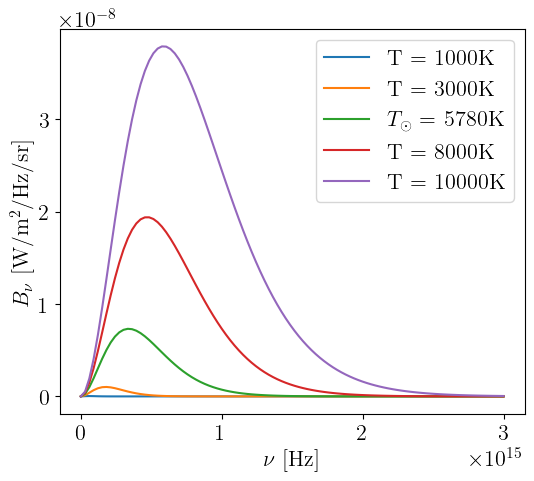

In [10]:
fig= plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for T in Temperatures:
    if T==5780:
        ax.plot(frequencies, Spectrum_freq_temperature(frequencies, T),\
                label = fr"$T_\odot$ = {T}K")
    else:
        ax.plot(frequencies, Spectrum_freq_temperature(frequencies, T), label = f"T = {T}K")
    

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")

plt.legend()
plt.show()

In [11]:
example_temp = {"CMB": 2.76, "Sun": 5780}  # Test T in K

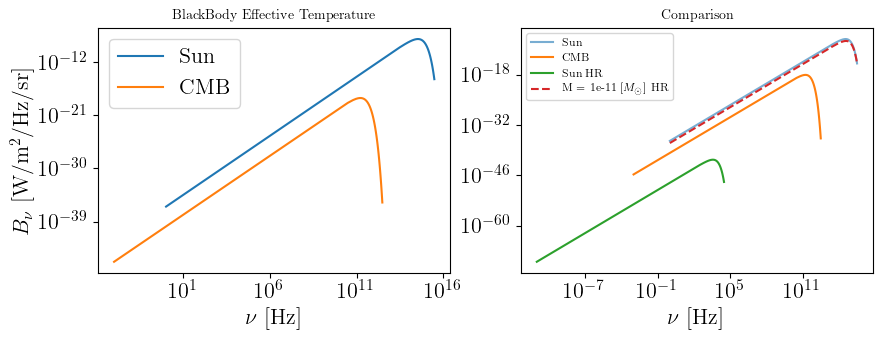

In [12]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)


ax1.loglog(frequencies, Spectrum_freq_temperature(frequencies, example_temp["Sun"]),\
        label = "Sun")
ax1.loglog(frequencies/1e3, Spectrum_freq_temperature(frequencies/1e3, example_temp["CMB"]),\
        label = "CMB")
ax1.set_xlabel(r"$\nu$ [Hz]")
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title("BlackBody Effective Temperature", fontsize=10)
ax1.legend()

ax2.loglog(frequencies, Spectrum_freq_temperature(frequencies, example_temp["Sun"]),\
        label = "Sun", alpha=0.6)
ax2.loglog(frequencies/1e3, Spectrum_freq_temperature(frequencies/1e3, example_temp["CMB"]),\
        label = "CMB")
ax2.loglog(frequencies/1e11, Spectrum_freq_mass(frequencies/1e11, example_masses["Sun"]),\
        label = "Sun HR")
ax2.loglog(frequencies, Spectrum_freq_mass(frequencies, 1e-11),\
        label = r"M = 1e-11 [$M_\odot$] HR", ls='--')
ax2.set_xlabel(r"$\nu$ [Hz]")
ax2.set_title("Comparison", fontsize=10)
ax2.legend(fontsize=8)

plt.tight_layout
plt.show()

### Blackbody spectrum for multiple masses

In [13]:
list_of_masses = [1, 2, 3, 4]
frequencies = np.linspace(1, 1e4, 100)
blackbody_spectrum = total_blackbody_spectrum(frequencies, list_of_masses)

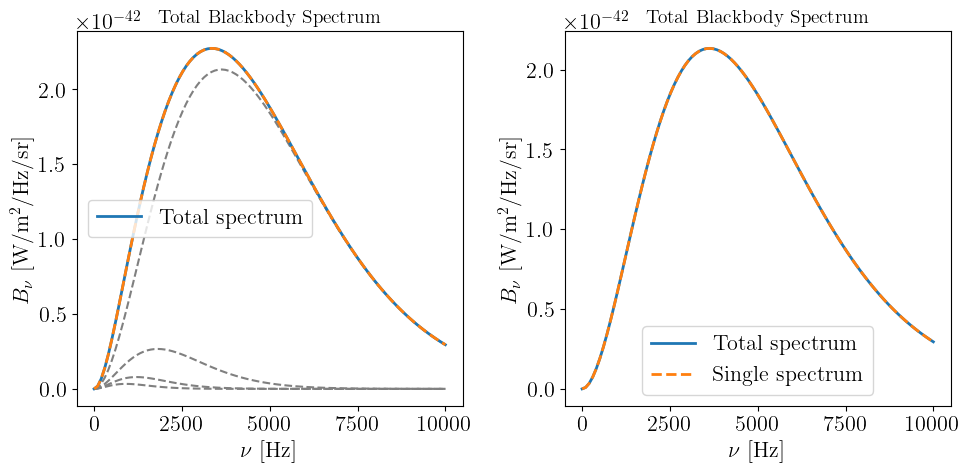

In [17]:
fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

total_spectrum = 0

for mass in list_of_masses:
    ax1.plot(frequencies, Spectrum_freq_mass(frequencies, mass), c='grey', ls='--')
    total_spectrum += Spectrum_freq_mass(frequencies, mass)
        
ax1.plot(frequencies, blackbody_spectrum, label='Total spectrum', lw=2)
ax1.plot(frequencies, total_spectrum, ls='--', c='tab:orange', lw=2)
ax1.set_xlabel(r'$\nu$ [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Total Blackbody Spectrum', fontsize=14)
ax1.legend()

## Testing that the multiple spectrum from 1 mass is the same as the single spectrum
ax2.plot(frequencies, total_blackbody_spectrum(frequencies, [1]), label='Total spectrum', lw=2)
ax2.plot(frequencies, Spectrum_freq_mass(frequencies, 1), label='Single spectrum', lw=2, ls='--')
ax2.set_xlabel(r'$\nu$ [Hz]')
ax2.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax2.set_title('Total Blackbody Spectrum', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

### Greybody factors check

In the original calculation of Hawking radiation the spectrum of emitted particles is

$$
N_\nu = \Gamma_\nu\frac{2h\nu^3}{c^2}\frac{1}{e^{h \nu/k_B T}-1},
$$

where the $\Gamma_\nu$ term signifies the *greybody factor*, that modifies the spectrum from a perfect blackbody. It acts as the absorption coefficient for scattering of a scalar field off the gravitational field of a BH.

For the *greybody* factors to not play an important role, we need:

$$
\lambda \lesssim R_{\rm S} = \frac{2 G M}{c^2} \Rightarrow M \gtrsim \frac{hc^3}{2GE}\quad {\rm or}\quad \nu \gtrsim \frac{c^3}{2GE}.
$$

Setting $E=E_{\rm LW} \sim 12.5$ eV, for the LW energy band, we get a constraint on the black hole masses:

In [18]:
E_LW_eV = 12.5
E_LW_J = E_LW_eV/E_JOULE_2_eV

In [19]:
mass_greybody_limit_gr = h*c**3/(2*G*E_LW_eV/E_JOULE_2_eV)*1000  # x1000 (to make grams)
mass_greybody_limit_Mo = mass_greybody_limit_gr/M_SOLAR_2_GRAMS

In [20]:
print(f"To avoid greybody factors, the BH mass need to be bigger than: {mass_greybody_limit_Mo} Mo")
print(f"To avoid greybody factors, the BH mass need to be bigger than: {mass_greybody_limit_gr} g")

To avoid greybody factors, the BH mass need to be bigger than: 3.3578507377362e-11 Mo
To avoid greybody factors, the BH mass need to be bigger than: 6.678765117357302e+22 g


<div class="alert alert-block alert-info">
<b>To avoid `Greybody` factors</b> 

To avoid *greybody* factors, we need the energy of the LW photons to overcome the effective potential of the BH. This corresponds to masses of: 
    
- $M_{\rm BH} \geq  3.35 \cdot 10^{-11} M_\odot$.
- $M_{\rm BH} \geq  6.68 \cdot 10^{22}$ g.    

</div>

-------------------------------

# Connection of energy and frequency/wavelength of photons <a name="Photons"></a>

In this section, we transform photons of specific energy their respective frequency or wavelength, and vice versa. This is useful to connect the standard energy range of the LW photons to their respective frequencies.

Return to TOC [here](#toc).

Sanity checks:

1) For 1 Hz, we get $4.136 \cdot 10^{-15}$ eV.
2) For 1 nm, we get $1239.8$ eV.

In [21]:
print(f"For 1 Hz, we get {energy_from_photons(nu=1)} eV.")
print(f"For 1 nm, we get {energy_from_photons(wavelength=1)} eV.")

For 1 Hz, we get 4.13599298763e-15 eV.
For 1 nm, we get 1239.9395040323614 eV.


In [22]:
print(f"For 4.136e-15 eV, we get {photons_from_energy(4.136e-15)[0]} Hz.")
print(f"For 1239.8 eV, we get {photons_from_energy(1239.8)[1]} nm.")

For 4.136e-15 eV, we get 1.0000016954501667 Hz.
For 1239.8 eV, we get 1.0001125214005173 nm.


The Lyman-Werner photons correspond to the $11.2-13.6$ eV energy range. What is the frequency and wavelength range?

In [23]:
nu_low, lamda_low = photons_from_energy(11.2)
nu_high, lamda_high = photons_from_energy(13.6)

In [24]:
print(f"The low energy (11.2 eV) corresponds to: {np.round(nu_low, 2)} Hz, and {np.round(lamda_low, 2)} nm.")
print(f"The high energy (13.2 eV) corresponds to: {np.round(nu_high, 2)} Hz, and {np.round(lamda_high, 2)} nm.")

The low energy (11.2 eV) corresponds to: 2707934958665828.0 Hz, and 110.71 nm.
The high energy (13.2 eV) corresponds to: 3288206735522791.5 Hz, and 91.17 nm.


In [25]:
print(f"The LW energy (11.2 eV) corresponds to a BB spectrum, with temperature: {np.round(nu_low/b_wien_freq, 2)} K.")
print(f"The LW energy (13.6 eV) corresponds to a BB spectrum, with temperature: {np.round(nu_high/b_wien_freq, 2)} K.")

The LW energy (11.2 eV) corresponds to a BB spectrum, with temperature: 46061.73 K.
The LW energy (13.6 eV) corresponds to a BB spectrum, with temperature: 55932.1 K.


Checking Wien's law, for peak frequency of the spectrum, with out blackbody spectra.

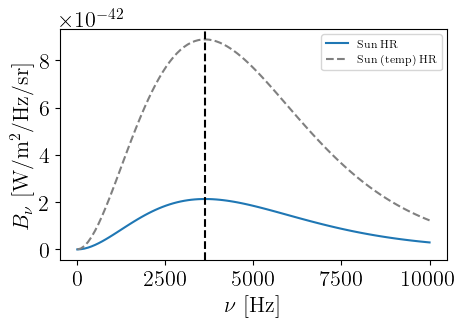

In [26]:
frequencies = np.linspace(1, 1e4, 100)

fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)

ax1.plot(frequencies, Spectrum_freq_mass(frequencies, example_masses["Sun"]),\
        label = "Sun HR")
ax1.plot(frequencies, Spectrum_freq_temperature(frequencies,\
                                                     Hawking_temperature_from_mass(example_masses["Sun"])),\
        label = "Sun (temp) HR", ls='--', c='grey')

# We calculate the peak of the spectrum using Wien's law (for a given mass)
ax1.axvline(x = photons_from_energy(peak_HR_energy_from_mass(example_masses["Sun"]))[0], ls='--', c='black')

ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_xlabel(r"$\nu$ [Hz]")
ax1.legend(fontsize=8)

plt.tight_layout
plt.show()

For $H^-$ dissociation, that indirectly leads to suppresion of $H_2$, we need $E_\gamma>0.8$ eV. To use the fitting formulas of [[1407.4039](https://arxiv.org/pdf/1407.4039)], we choose a limit of $E_\gamma>2.0$ eV. This leads to frequency and wavelength:

In [27]:
nu_Hm, lamda_Hm = photons_from_energy(2.0)
print(f"The H- energy (2.0 eV) corresponds to: {np.round(nu_Hm, 2)} Hz, and {np.round(lamda_Hm, 2)} nm.")

The H- energy (2.0 eV) corresponds to: 483559814047469.4 Hz, and 619.97 nm.


In [28]:
## Wien's law to find temperature of BB spectrum, at peak frequency
T_Hm = nu_Hm/b_wien_freq
print(f"The H- energy (2.0 eV) corresponds to a BB spectrum, with temperature: {np.round(T_Hm, 2)} K.")

The H- energy (2.0 eV) corresponds to a BB spectrum, with temperature: 8225.31 K.


### Massless particles check

Ignoring the neutrinos and talking the electron as the smallest nonzero rest mass particle, massless particles will dominate the HR when:

$$
k_B T \lesssim m_e c^2 \Rightarrow M_{\rm BH} \gtrsim \frac{\hbar c}{8 \pi G m_e}.
$$

In [29]:
massless_limit_gr = hbar*c/(8*pi*G*mass_electron)*1000  # x1000 to make grams
massless_limit_Mo = massless_limit_gr/M_SOLAR_2_GRAMS

In [30]:
print(f"To be in the massless limit, the BH mass need to be bigger than: {massless_limit_Mo} Mo")
print(f"To be in the massless limit, the BH mass need to be bigger than: {massless_limit_gr} g")

To be in the massless limit, the BH mass need to be bigger than: 1.0402255145695818e-17 Mo
To be in the massless limit, the BH mass need to be bigger than: 2.0690085484788984e+16 g


<div class="alert alert-block alert-info">
<b>To be in the `massless` limit</b> 

To be in the *massless* limit, we need the energy of the BH to be lower than the rest energy of the electron. This corresponds to masses of: 
    
- $M_{\rm BH} \geq  1.0 \cdot 10^{-17} M_\odot$.
- $M_{\rm BH} \geq  2.1 \cdot 10^{16}$ g.    

</div>

----------------------------------------

# Age with redshift <a name="time_redshift"></a>

In this section we connect the age of the universe since the BB, with redshift. We combine this with PBH formation and evolution due to Hawking evaporation (in the next section).

Return to TOC [here](#toc).

__Sanity checks__: We compare the `Astropy` functions with the analytical `age_at_redshift`. We consider a flat LCDM universe with $\Omega_m = 0.3$ and $H_0 = 70$ Mpc/km/s.

In [31]:
# Age of the universe today in Gyrs
cosmo.age(0).value, age_at_redshift(0)

(13.466983947061877, 13.494854310342225)

In [32]:
redshift_range = np.linspace(10, 30, 100)
redshift_sparse = redshift_range[::20]

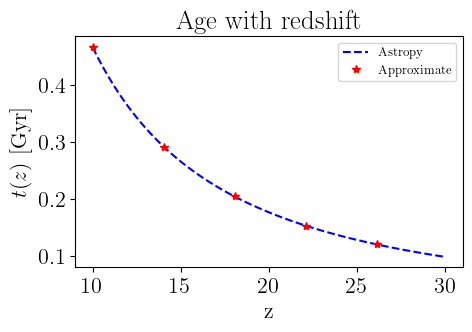

In [33]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshift_range, cosmo.age(redshift_range).value, label = 'Astropy', c='blue', ls='--')
ax1.plot(redshift_sparse, age_at_redshift(redshift_sparse), label = 'Approximate', c='red', ls=' ', marker='*')

ax1.set_ylabel('$t(z)$ [Gyr]')
ax1.set_xlabel('z')
ax1.set_title('Age with redshift')
ax1.legend(fontsize = 9)

plt.show()

In [34]:
example_eras = {"BBN": 4e8, "MD=RD": 3400, "CMB": 1100, "Reionisation": 15, r"MD=$\Lambda$D": 0.4}  # Eras in redshift

In [35]:
redshift_range = np.logspace(-1, 9, 500)
t_age = age_at_redshift(redshift_range)

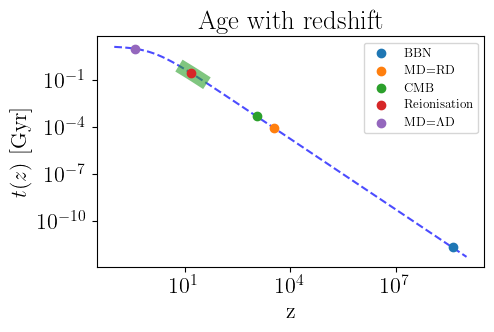

In [36]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(redshift_range, t_age, c='blue', ls='--', alpha=0.7)

bool_redshift_range = (redshift_range>10)*(redshift_range<30)
ax1.loglog(redshift_range[bool_redshift_range], t_age[bool_redshift_range], ls='-',\
           c='tab:green', lw=10, alpha=0.6)

for i, items in enumerate(list(example_eras)):
    ax1.scatter(example_eras[items], age_at_redshift(example_eras[items]), label=f"{items}", zorder=100)

ax1.set_ylabel(r'$t(z)$ [Gyr]')
ax1.set_xlabel('z')
ax1.set_title('Age with redshift')
ax1.legend(fontsize = 9)

plt.show()

**NB**: We are interested in BHs, that will emit at the critical temperature, at the redshift range of the formation of the seed BHs. But we can set a general constraint, by demanding that **PBHs to not have evaporated, before $z=10$**!

In [37]:
print(f"The age of the universe are redshift z=10 is: {age_at_redshift(10)} Gyr.")

The age of the universe are redshift z=10 is: 0.46685140701548333 Gyr.


We want $t_{\rm evap} \geq 0.47$ Gyrs.

In [38]:
print(f"The mass of PBHs that evaporate at z=10 is: {mass_from_evaporation_time(age_at_redshift(10))} Mo,\
 or {mass_from_evaporation_time(age_at_redshift(10))*M_SOLAR_2_GRAMS} g.")

The mass of PBHs that evaporate at z=10 is: 2.809867855879623e-20 Mo, or 55888271653445.71 g.


<div class="alert alert-block alert-info">
<b>Constraints from evaporation redshift</b> 

We want $t_{\rm evap} \geq t_{\rm age}(z=10)$, which leads to masses bigger than:

- $M_{\rm BH} \geq  2.81 \cdot 10^{-20} M_\odot$.
- $M_{\rm BH} \geq  5.59 \cdot 10^{13}$ g.   

</div>

---------------------------------------------------

# Formation of BHs <a name="BH_formation"></a>

An estimate of the maximum masses of PBHs with formation time (since the Big Bang) is:

$$
M_{\rm PBH} \sim M_H = \frac{4}{3}\pi \rho \left( \frac{1}{H}\right)^3 \sim 10^{15} \left( \frac{t}{10^{-23}{\rm s}} \right) {\rm gr}.
$$

This means that till $1$s we will already have BHs of the order of $10^5\ M_\odot$, which means that we can consider for all masses of interest a formation time $t_{\rm form} \rightarrow 0$.

Return to TOC [here](#toc).

**Sanity check**: 

- For $1$s we expect a $M_{\rm BH}$ of about $10^5 M_{\odot}$.
- For $10^{-23}$s we expect a $M_{\rm BH}$ of about $10^{15}$ gr.

In [39]:
t_form_sec = 1/(YEARS_2_SEC*1e9)  #To transform it to Gyr
mass_form = formation_mass_at_time(t_form_sec)

print(f"The mass of a PBH formed at 1s can reach {mass_form} Mo.")

t_form_sec = 1e-23/(YEARS_2_SEC*1e9)  #To transform it to Gyr
mass_form = formation_mass_at_time(t_form_sec)

print(f"The mass of a PBH formed at 1e-23s can reach {np.log10(mass_form*M_SOLAR_2_GRAMS)} in log gr.")

The mass of a PBH formed at 1s can reach 50276.52086475617 Mo.
The mass of a PBH formed at 1e-23s can reach 15.0 in log gr.


**NB**: The range of redshifts $z>5000$ is out of scope for `astropy` or our `age_at_redshift` function

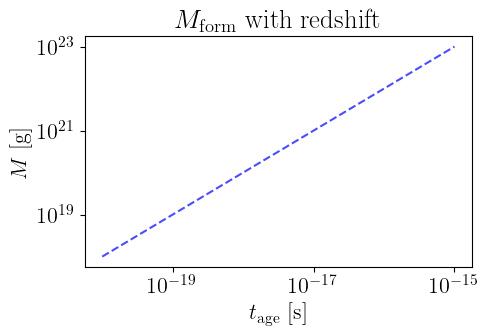

In [40]:
age_range = np.logspace(-20, -15, 20)/(YEARS_2_SEC*1e9)  #To transform it to Gyr
mass_form = formation_mass_at_time(age_range)

fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(age_range*(YEARS_2_SEC*1e9), mass_form*M_SOLAR_2_GRAMS, c='blue', ls='--', alpha=0.7)

ax1.set_ylabel(r'$M$ [g]')
ax1.set_xlabel(r'$t_{\rm age}$ [s]')
ax1.set_title(r'$M_{\rm form}$ with redshift')

plt.show()

**NB**: We see that for the mass range of interest ($M \sim 10^{22}$gr), the formation time corresponds practically to $t_i \rightarrow 0, z \rightarrow \infty$.

--------------------------------------------------------------------

# Evaporation time due to HR <a name="BH_evaporation"></a>

BHs that emit HR evolve with time, since they lose energy (mass). We quantify this evolution and compare with common eras of the universe!

It is worth noting that the evaporation time of a BH will depend on its emission spectrum, i.e. it will radiate stronger at its last stages and as a consequence evolve faster. Also, the HR of a BH can include other particles than photons, which will make the evolution slightly different (faster).

Below, we consider two cases:

- `evaporation_time_from_mass`: involves only photon emission
- `effective_evaporation_time_from_mass`: involves photons + other particles (this is based on [[here](https://arxiv.org/pdf/2203.05743)].

**NB**: Beware, both functions accept $M_{\rm BH}$ in $M_\odot$.

The standard `evaporation_time_from_mass` is given by:

$$
t_{\rm ev}= \frac{15360 \pi G^2 M_{\rm BH}^3}{3 \hbar c^4} = 2.1\times10^{67}\, \left(\frac{M_{\rm BH}}{M_\odot}\right)^3 \: {\rm yr}.
$$

Return to TOC [here](#toc).

__Sanity check__: Comparison with analytical calculations: we expect for $1 M_\odot$ black hole, an evaporation time of $\sim 2 \cdot 10^{67}$ years.

In [41]:
print(f'The t_HR for a 1 Mo BH is: {evaporation_time_from_mass(1)*1e9} years.')
print(f'The effective t_HR for a 1 Mo BH is: {effective_evaporation_time_from_mass(1)*1e9} years.')
print(f'Then t_HR is {evaporation_time_from_mass(1)/effective_evaporation_time_from_mass(1)} bigger than t_eff_HR.')

The t_HR for a 1 Mo BH is: 2.1043645818117622e+67 years.
The effective t_HR for a 1 Mo BH is: 2.1043645817433174e+67 years.
Then t_HR is 1.000000000032525 bigger than t_eff_HR.


The difference in time evolution is more profound for *smaller masses*:

In [42]:
print(f'The t_HR for a 5e-20 Mo BH is: {evaporation_time_from_mass(5e-20)/1e9} Gyears.')
print(f'The t_HR for a 1e-19 Mo BH is: {evaporation_time_from_mass(1e-19)/1e9} Gyears.')

The t_HR for a 5e-20 Mo BH is: 2.630455727264702e-09 Gyears.
The t_HR for a 1e-19 Mo BH is: 2.1043645818117617e-08 Gyears.


As a first step, we compare the two evaporation times with the results in [[2312.15062](https://arxiv.org/pdf/2312.15062)], (Section B, p.11). 

**NB**: To find evaporation at similar times, we are using different initial masses ($4$ times bigger for $t_{\rm eff}$, since the extra emission allows for BHs to evaporate faster).

In [43]:
## Create mass range and transform to solar masses.
mass_range = (np.linspace(1.4, 2.2, 10)*2.5e13)/M_SOLAR_2_GRAMS
mass_range_eff = (np.linspace(1.4, 2.2, 10)*1e14)/M_SOLAR_2_GRAMS

## Calculate the evaporation time in two cases.
t_evap = evaporation_time_from_mass(mass_range)

t_evap_eff = np.zeros_like(mass_range_eff)
for idx, Mo in enumerate(mass_range_eff):
    t_evap_eff[idx] = effective_evaporation_time_from_mass(Mo)

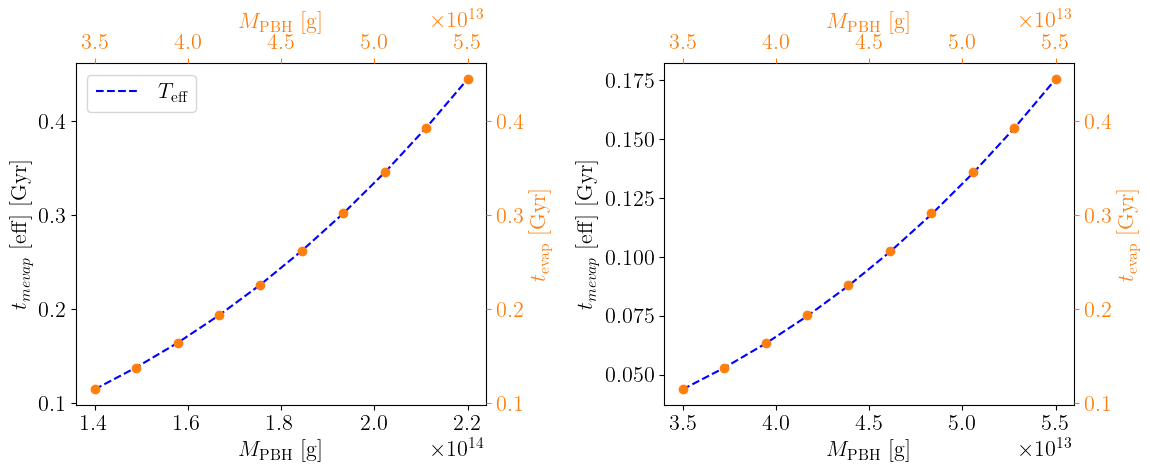

In [44]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(121, label="2", frame_on=False)

ax3 = fig.add_subplot(1, 2, 2)
ax4=fig.add_subplot(122, label="2", frame_on=False)


### Grams
ax1.plot(mass_range_eff*M_SOLAR_2_GRAMS, t_evap, c='blue',\
         ls='--', label=r'$T_{\rm eff}$')
ax1.set_ylabel('$t_{\rm evap}$ [eff] [Gyr]')
ax1.set_xlabel(r'$M_{\rm PBH}$ [g]')
ax1.legend()

ax2.scatter(mass_range*M_SOLAR_2_GRAMS, t_evap, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$M_{\rm PBH}$ [g]', color="C1") 
ax2.set_ylabel(r'$t_{\rm evap}$ [Gyr]', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")


### Solar Masses
ax3.plot(mass_range*M_SOLAR_2_GRAMS, t_evap_eff, c='blue', ls='--')
ax3.set_ylabel('$t_{\rm evap}$ [eff] [Gyr]')
ax3.set_xlabel(r'$M_{\rm PBH}$ [g]')

ax4.scatter(mass_range*M_SOLAR_2_GRAMS, t_evap, color="C1")
ax4.xaxis.tick_top()
ax4.yaxis.tick_right()
ax4.set_xlabel(r'$M_{\rm PBH}$ [g]', color="C1") 
ax4.set_ylabel(r'$t_{\rm evap}$ [Gyr]', color="C1")       
ax4.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
ax4.tick_params(axis='x', colors="C1")
ax4.tick_params(axis='y', colors="C1")

plt.tight_layout()
plt.show()

We now compare the evaporation times of a number of BH masses, with the different eras of the universe

In [45]:
### A number of BH masses (turned to solar for evaporation time calculation)
mass_range = 10**np.array([12., 13., 13.5, 14.])/M_SOLAR_2_GRAMS
t_evap = evaporation_time_from_mass(mass_range)

## Transform to redshifts (for given cosmology)
z_evap = z_at_value(cosmo.age, t_evap * u.Gyr, zmin=0, zmax=1e8).value

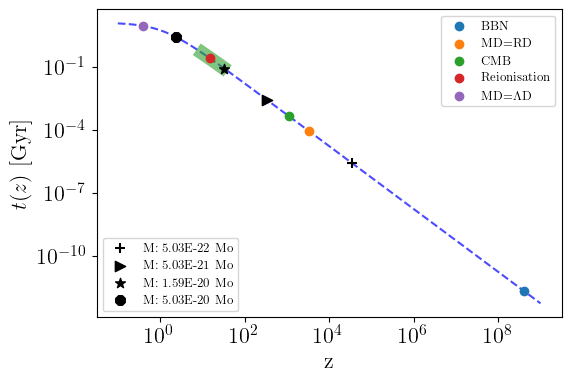

In [46]:
fig = plt.figure(figsize = (6, 4))
ax1 = fig.add_subplot(1, 1, 1)


ax1.loglog(redshift_range, t_age, c='blue', ls='--', alpha=0.7)

bool_redshift_range = (redshift_range>10)*(redshift_range<30)
ax1.loglog(redshift_range[bool_redshift_range], t_age[bool_redshift_range], ls='-',\
           c='tab:green', lw=10, alpha=0.6)

for i, items in enumerate(list(example_eras)):
    ax1.scatter(example_eras[items], age_at_redshift(example_eras[items]), label=f"{items}", zorder=100)

markers_list = ['+', '>', '*', '8']
for i, mass in enumerate(mass_range):
    ax1.scatter(z_evap[i], t_evap[i], label=f'M: {(mass):.2E} Mo', marker=markers_list[i], s=55, zorder=200, c='black')   


ax1.set_ylabel('$t(z)$ [Gyr]')
ax1.set_xlabel('z')

handles, labels = ax1.get_legend_handles_labels()

second_legend = ax1.legend(handles[5:], labels[5:], fontsize = 9, loc='lower left')
ax1.add_artist(second_legend)

ax1.legend(handles[0:5], labels[0:5], fontsize = 9, loc='upper right')


plt.show()

We see that masses of the order of $\sim 10^{-20} M_\odot$ are needed to be in the redshift range of interest. We will now look into that in more detail, by inverting the equations above and finding the masses, given an evaporation time. 

<div class="alert alert-block alert-warning">
    <b>NB:</b> In reality, we are <b>not</b> looking for BHs that evaporate at the redshift of interest - we just want them to emit at a critical intensity. More on that below.
</div>

**Sanity check**: The maximum mass of a BH that could have evaporated due to HR within the age of the Universe ($\rm \sim 13.7 \: Gyr$) is $\rm 9 \times 10^{-20} \: M_{\odot}$ (or about $\sim 1.8 \times 10^{14}$ gr).

In [47]:
print(f'A BH evaporating at z=0, will have mass: {mass_from_evaporation_time(age_at_redshift(0))} Mo')

A BH evaporating at z=0, will have mass: 8.623476923929839e-20 Mo


Let's assume a redshift range of interest $z\ \epsilon\ [10, 30]$. We find the mass range that evaporates during this range:

In [48]:
### Full redshift and mass range
z_full = np.linspace(1, 50, 100)
t_evap_full = age_at_redshift(z_full)
masses_full = mass_from_evaporation_time(t_evap_full)

### Redshift range of interest
z_range_bool = (z_full>10)*(z_full<30)

### Checking the effects of the effective evaporation time
masses_eff_full = np.logspace(-18.5, -19.2, 100)
t_eff_full = np.zeros_like(masses_eff_full)
for idx, Mo in enumerate(masses_eff_full):
    t_eff_full[idx] = effective_evaporation_time_from_mass(Mo)
    
t_evap_min = np.min(t_evap_full[z_range_bool])
t_evap_max = np.max(t_evap_full[z_range_bool])

t_eff_bool = (t_eff_full>t_evap_min)*(t_eff_full<t_evap_max)
z_eff_full = z_at_value(cosmo.age, t_eff_full * u.Gyr, zmin=0, zmax=1e8).value
z_eff_range = z_at_value(cosmo.age, t_eff_full[t_eff_bool] * u.Gyr, zmin=0, zmax=1e8).value

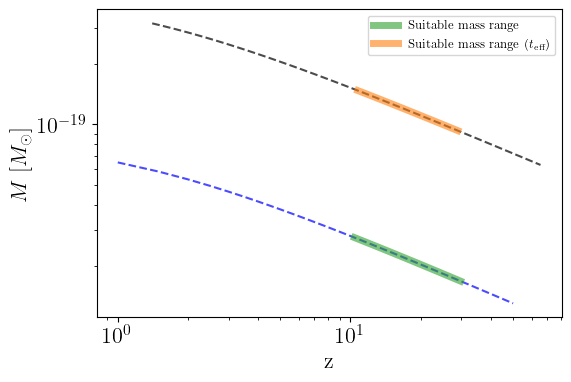

In [49]:
fig = plt.figure(figsize = (6, 4))
ax1 = fig.add_subplot(1, 1, 1)


ax1.loglog(z_full, masses_full, c='blue', ls='--', alpha=0.7)
ax1.loglog(z_full[z_range_bool], masses_full[z_range_bool], ls='-',\
           c='tab:green', lw=5, alpha=0.6, label = 'Suitable mass range')

ax1.loglog(z_eff_full, masses_eff_full, c='black', ls='--', alpha=0.7)
ax1.loglog(z_eff_range, masses_eff_full[t_eff_bool], ls='-',\
           c='tab:orange', lw=5, alpha=0.6, label = r'Suitable mass range ($t_{\rm eff}$)')

ax1.set_ylabel('$M\ [M_\odot]$')
ax1.set_xlabel('z')
ax1.legend(fontsize = 9)


plt.show()

**Sanity check**: Evaporation times and redshifts for given mass, and inverse.

In [50]:
z_check = 15
t_check = age_at_redshift(z_check)

print(f"At z={z_check}, the age of the universe is: {t_check} Gyr.")

At z=15, the age of the universe is: 0.26617870678164357 Gyr.


In [51]:
mass_t_check = mass_from_evaporation_time(t_check)
mass_z_check = mass_from_evaporation_redshift(z_check)

print(f"Mass from time is: {mass_t_check} [Mo]")
print(f"Mass from redshift is: {mass_z_check} [Mo]")

Mass from time is: 2.3299723953264367e-20 [Mo]
Mass from redshift is: 2.3299723953264367e-20 [Mo]


In [52]:
print(f"For `mass_t_check`, the evaporation time is: {evaporation_time_from_mass(mass_t_check)} Gyr.")
print(f"For `mass_z_check`, the evaporation time is: {evaporation_redshift_from_mass(mass_z_check)}.")

For `mass_t_check`, the evaporation time is: 0.2661787067816425 Gyr.
For `mass_z_check`, the evaporation time is: 14.977958721734419.


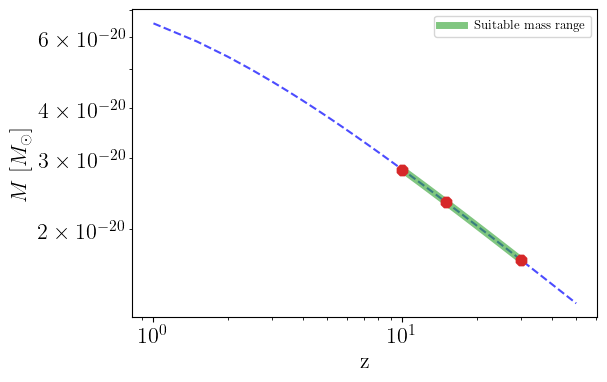

In [53]:
z_evap_limits = np.array([10., 15., 30.])

mass_evap = np.zeros_like(z_evap_limits)

for idx, z in enumerate(z_evap_limits):
    mass_evap[idx] = mass_from_evaporation_redshift(z)

fig = plt.figure(figsize = (6, 4))
ax1 = fig.add_subplot(1, 1, 1)


ax1.loglog(z_full, masses_full, c='blue', ls='--', alpha=0.7)
ax1.loglog(z_full[z_range_bool], masses_full[z_range_bool], ls='-',\
           c='tab:green', lw=5, alpha=0.6, label = 'Suitable mass range')

ax1.scatter(z_evap_limits, mass_evap, zorder=100, marker='8', color='tab:red', s=65)

ax1.set_ylabel('$M\ [M_\odot]$')
ax1.set_xlabel('z')
ax1.legend(fontsize = 9)


plt.show()

In [54]:
mass_range = masses_full[z_range_bool]
mass_low = np.min(mass_range)
mass_high = np.max(mass_range)

mass_eff_low = np.min(masses_eff_full[t_eff_bool])
mass_eff_high = np.max(masses_eff_full[t_eff_bool])

print(f"The min BH mass corresponding to z~30 is: {mass_low} Mo, or 10^{np.log10(mass_low*M_SOLAR_2_GRAMS)} gr.")
print(f"The max BH mass corresponding to z~10 is: {mass_high} Mo, or 10^{np.log10(mass_high*M_SOLAR_2_GRAMS)} gr.")
print()
print("For the effective evaporation time, this corresponds to:\n")
print(f"The min BH mass corresponding to z~30 is: {mass_eff_low} Mo, or 10^{np.log10(mass_eff_low*M_SOLAR_2_GRAMS)} gr.")
print(f"The max BH mass corresponding to z~10 is: {mass_eff_high} Mo, or 10^{np.log10(mass_eff_high*M_SOLAR_2_GRAMS)} gr.")

The min BH mass corresponding to z~30 is: 1.6819123899397902e-20 Mo, or 10^13.524438152971193 gr.
The max BH mass corresponding to z~10 is: 2.759670289880554e-20 Mo, or 10^13.73949198119001 gr.

For the effective evaporation time, this corresponds to:

The min BH mass corresponding to z~30 is: 9.32603346883218e-20 Mo, or 10^14.268331752821405 gr.
The max BH mass corresponding to z~10 is: 1.471217112194565e-19 Mo, or 10^14.466311550801203 gr.


So we see that a very narrow range of masses correspond to the redshifts of interest! The effective model can evaporate bigger masses at the same redshift range, since emission to all particles, can make BH evaporation more efficient.

### Half-time of mass evolution

To quantify more clearly the evolution of masses, we calculate their respective half-time, i.e. the time needed for a BH mass of $M_i$ to become $M_i/2$. 

This should give a quick estimate of mass evolution, but keep also in mind that due to the scalings of mass evolution, the latter becomes faster as the masses decrease.

The mass half-time is given by:

$$
t_{1/2} = \frac{7}{8} \frac{M_i^3}{C}, 
$$

where $C$ is:

$$
C = \frac{3}{256} \frac{c^6 \sigma}{\pi^3 G^2} \left(\frac{\hbar}{k_B} \right)^4.
$$

In [55]:
mass_range = (np.linspace(1.4, 2.2, 10)*2.5e13)/M_SOLAR_2_GRAMS


## Calculate the evaporation time.
t_evap = evaporation_time_from_mass(mass_range)

## Calculate the half-time.
t_half = mass_evolution_half_time(mass_range)


## Same calculations for redshifts
z_evap = z_at_value(cosmo.age, t_evap * u.Gyr, zmin=0, zmax=1e8).value
z_half = z_at_value(cosmo.age, t_half * u.Gyr, zmin=0, zmax=1e8).value

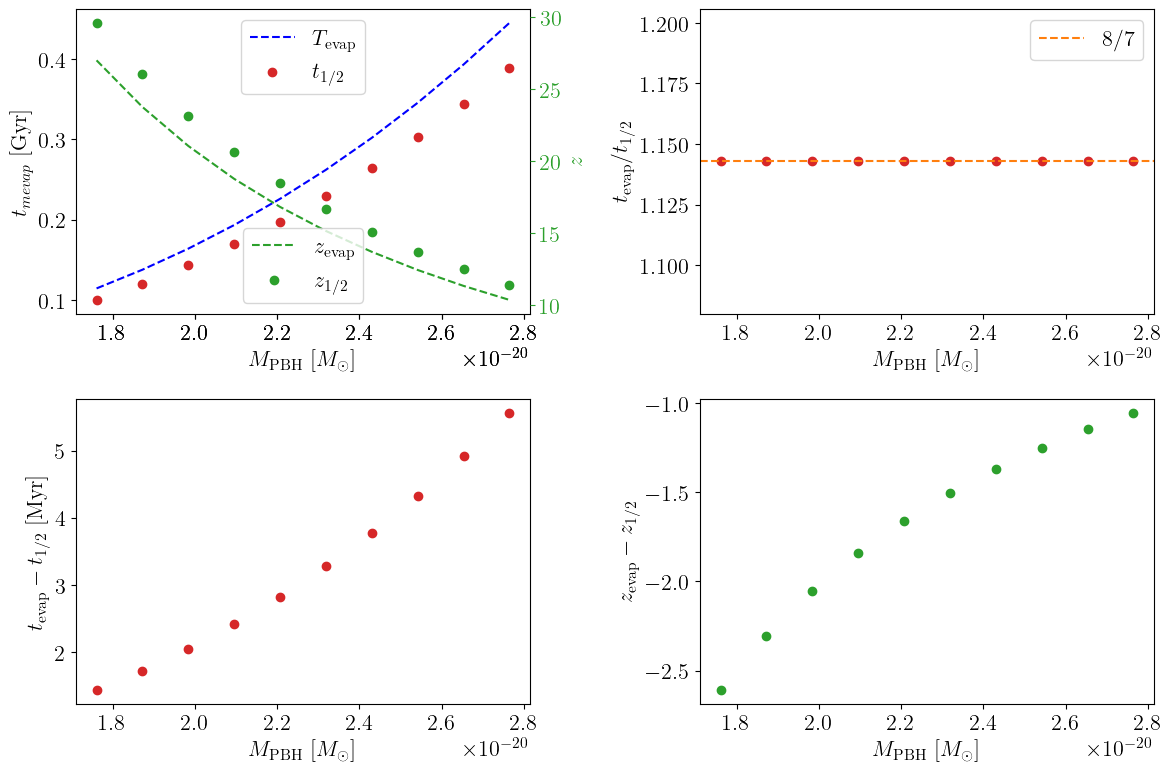

In [56]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(221, label="2", frame_on=False)

ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 3)

ax5 = fig.add_subplot(2, 2, 4)


ax1.plot(mass_range, t_evap, c='blue',\
         ls='--', label=r'$T_{\rm evap}$')
ax1.scatter(mass_range, t_half, color="tab:red", label=r'$t_{1/2}$')

ax1.set_ylabel('$t_{\rm evap}$ [Gyr]')
ax1.set_xlabel(r'$M_{\rm PBH}$ [$M_\odot$]')
ax1.legend(loc='upper center')

ax2.plot(mass_range, z_evap, c='C2',\
         ls='--', label=r'$z_{\rm evap}$')
ax2.scatter(mass_range, z_half, color="C2", label=r'$z_{1/2}$')
ax2.yaxis.tick_right()
ax2.set_ylabel(r'$z$', color="C2")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C2")
ax2.legend(loc='lower center')


###########################

ax3.scatter(mass_range, t_evap/t_half, color="tab:red")
ax3.axhline(y=8/7, ls='--', c='tab:orange', label=r'$8/7$')

ax3.set_ylabel(r'$t_{\rm evap}/t_{1/2}$')
ax3.set_xlabel(r'$M_{\rm PBH}$ [$M_\odot$]')
ax3.legend()


ax4.scatter(mass_range, (t_evap-t_half)*100, color="tab:red")
ax4.set_ylabel(r'$t_{\rm evap}-t_{1/2}$ [Myr]')
ax4.set_xlabel(r'$M_{\rm PBH}$ [$M_\odot$]')


ax5.scatter(mass_range, z_evap-z_half, color="C2")
ax5.set_ylabel(r'$z_{\rm evap}-z_{1/2}$') 
ax5.set_xlabel(r'$M_{\rm PBH}$ [$M_\odot$]')


plt.tight_layout()
plt.show()

### Mass evolution with redshift

We study how BHs evolve when changing their initial mass and the redshift of interest (final redshift).

**NB**: Since there is an issue with `astropy` and our `age_at_redshift` function, we cannot evolve masses for redshifts above $z>5000$. We will start our investigation with redshifts of the order of $1000$.

In [57]:
z_initial = 1000
z_check = 15

Let's start by checking with our evaporation calculations:

- We'll calculate when we expect a BH to evaporate
- Cross-check with our mass evolution that it evaporates at similar times and how its mass changed from $z=1000$ to $z_{\rm evap}$.

In [58]:
mass_z_check = mass_from_evaporation_redshift(z_check)

redshift_range = np.logspace(1, 3, 50)
M_evolved = np.ones_like(redshift_range)

for idx_z, z in enumerate(redshift_range):
    M_evolved[idx_z] = mass_evolution_from_HR(mass_z_check, z_initial, z, mass_units='solar', time_units='redshift')

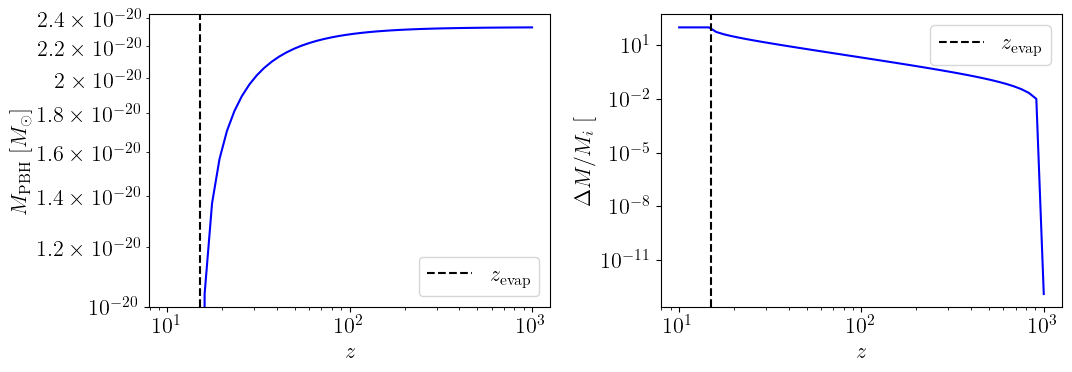

In [59]:
fig = plt.figure(figsize = (11, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.loglog(redshift_range, M_evolved, c='blue', ls='-')
ax1.axvline(x=z_check, ls='--', c='black', label=r'$z_{\rm evap}$')
ax1.set_xlabel('$z$')
ax1.set_ylabel(r'$M_{\rm PBH}$ [$M_\odot$]')
ax1.legend()            

ax2.loglog(redshift_range, (mass_z_check - M_evolved)/mass_z_check*100, c='blue', ls='-')
ax2.axvline(x=z_check, ls='--', c='black', label=r'$z_{\rm evap}$')
ax2.set_xlabel('$z$')
ax2.set_ylabel(r'$\Delta M/M_i$ [%]')
ax2.legend() 

plt.tight_layout()
plt.show()

Let's see now how the temperature and blackbody spectrum of this BH change with time

In [60]:
T_evolved = np.ones_like(M_evolved[M_evolved>0])

for idx_M, MBH in enumerate(M_evolved[M_evolved>0]):
    T_evolved[idx_M] = Hawking_temperature_from_mass(MBH)

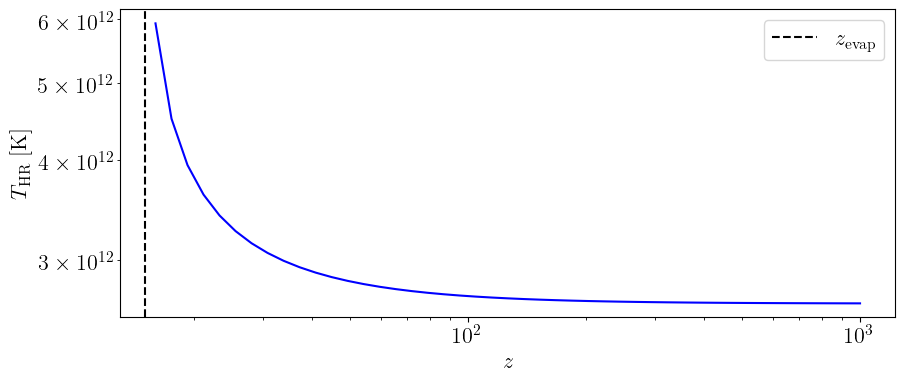

In [61]:
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(redshift_range[M_evolved>0], T_evolved, c='blue', ls='-')
ax1.axvline(x=z_check, ls='--', c='black', label=r'$z_{\rm evap}$')
ax1.set_xlabel('$z$')
ax1.set_ylabel(r'$T_{\rm HR}$ [K]')
ax1.legend() 

plt.show()

**NB**: 

1. The temperature is practically constant, till the very last stages of evaporation.
2. The temperatures are very large to plot BB spectra!

Let's choose now a mass that would have a HR blackbody with characteristic temperature $T \sim 8000$ K, at $z_{\rm initial}=1000$, and see how it evolves till our redshift of interest.

In [69]:
M_BH_critical = BH_mass_from_Hawking_temperature(T_Hm, units='cgs')
M_BH_critical, M_BH_critical/M_SOLAR_2_GRAMS

(1.4908669399864009e+22, 7.495560281480144e-12)

In [64]:
M_evolved_crit = np.ones_like(redshift_range)

for idx_z, z in enumerate(redshift_range):
    M_evolved_crit[idx_z] = mass_evolution_from_HR(M_BH_critical, z_initial, z, mass_units='solar', time_units='redshift')

In [65]:
T_evolved_crit = np.ones_like(M_evolved_crit[M_evolved_crit>0])

for idx_M, MBH in enumerate(M_evolved_crit[M_evolved_crit>0]):
    T_evolved_crit[idx_M] = Hawking_temperature_from_mass(MBH, units='cgs')

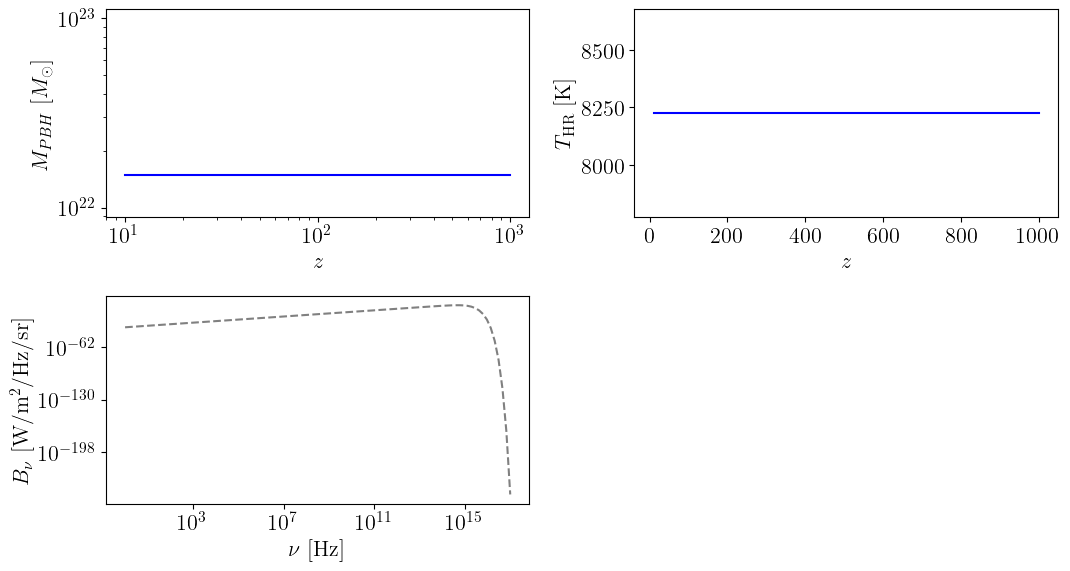

In [68]:
fig = plt.figure(figsize = (11, 6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.loglog(redshift_range, M_evolved_crit, c='blue', ls='-')
ax1.set_xlabel('$z$')
ax1.set_ylabel(r'$M_{PBH}$ [$M_\odot$]')

ax2.plot(redshift_range[M_evolved_crit>0], T_evolved_crit, c='blue', ls='-')
ax2.set_xlabel('$z$')
ax2.set_ylabel(r'$T_{\rm HR}$ [K]')

frequencies = np.logspace(0, 17, 100)    
ax3.loglog(frequencies, Spectrum_freq_temperature(frequencies, T_evolved_crit[0]), c='grey', ls='--')
ax3.set_xlabel(r'$\nu$ [Hz]')
ax3.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")

plt.tight_layout()
plt.show()

When does a $M_{\rm BH} = 7.5 \times 10^{-12} M_\odot$ (with $T_{\rm HR} = 8000$ K) evaporate?

In [70]:
print(f"The evaporation time of a BH mass {M_BH_critical/M_SOLAR_2_GRAMS} Mo is \
{evaporation_time_from_mass(M_BH_critical/M_SOLAR_2_GRAMS)} Gyr.")

The evaporation time of a BH mass 7.495560281480144e-12 Mo is 8.862031458467923e+24 Gyr.


So at a time much larger than the Universe's age, since the BB!

<div class="alert alert-block alert-warning">
  <b>NB:</b> Unless the BHs are evaporating close to the redshift of interest, we do not expect to see any time variation on the quantities of interest!
</div>

We confirm the above by finding the initial BH mass ($z \rightarrow \infty$) that would lead to a specific temperature at a redshift of interest. Here we choose: $T_{\rm crit} \sim 8000$ K and $z\ \epsilon\ (10, 30)$.

In [71]:
print(f'For z=10, the initial BH mass is: {initial_mass_with_Tcrit_and_z(10, T_Hm)} Mo.')
print(f'For z=30, the initial BH mass is: {initial_mass_with_Tcrit_and_z(30, T_Hm)} Mo.')

For z=10, the initial BH mass is: 7.495560281480156e-12 Mo.
For z=30, the initial BH mass is: 7.495560281480156e-12 Mo.


In [72]:
z_range = np.linspace(10, 30, 5)
Temp_range = np.logspace(3, 6, 4)

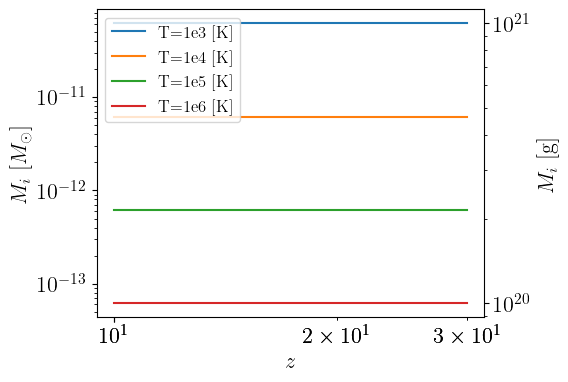

In [73]:
fig= plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, label="2", frame_on=False)


for T in Temp_range:
    ax1.loglog(z_range, initial_mass_with_Tcrit_and_z(z_range, T),\
            label = f"T=1e{int(np.log10(T))} [K]")

ax1.set_ylabel(r"$M_i\ [M_\odot]$")
ax1.set_xlabel(r"$z$")
ax1.legend(fontsize=12)

ax2.loglog(z_range, initial_mass_with_Tcrit_and_z(z_range, T)*M_SOLAR_2_GRAMS, ls=' ')
ax2.yaxis.tick_right()
ax2.set_ylabel(r"$M_i$ [g]")
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y')

# plt.show()
plt.savefig("Figures/mass_evolution_redshift.png", bbox_inches="tight")

--------------------------

# DCBHs requirements <a name="DCBHs_requirements"></a>

Our scenario involves the direct collapse of metal-free gas halos, where the masses of the initial BHs are of the order of $\rm 10^5-10^6 \: M_\odot$. This requires to avoid significant fragmentation of the collapsing gas cloud (ignoring angular momentum for our case) and high-accretion rates.

Key prerequisites of this scenario are:

- The presence of an _atomic cooling halo_, i.e. a halo with no presence of metals or molecules that can cool efficiently and lead to significant fragmentation of the original cloud into smaller clumps, with **equilibrium temperature of the order of $T_{\rm crit} \sim 8000$ K** and for the absence of heavy elements at **redshifts of the order of $z \sim 15$**.
- The **presence of strong UV radiation in the Lyman-Werner (LW) range ($11.2-13.6$ eV)**, that is able to suppress the formation of molecular hydrogen H$_2$, or in the range $h\nu>2$ eV, to photodissociate $H^-$ and indirectly block $H_2$.
- Strength of radiation at the level of **$J_{\rm crit} \sim 10^2 - 10^4$** in conventional units of $10^{-21}$ erg/s/cm$^2$ /Hz/sr (or the equivalent critical value, depending on temperature of the blackbody).


Return to TOC [here](#toc).

## Critical LW intensity with Temperature

The critical intensity $J_{\rm crit, 21}$ depends on the ratio of the photodissociation coefficients of $H^-$ and $H_2$. We use a fit on the data from [[1407.4039](https://arxiv.org/pdf/1407.4039)].

In [74]:
import scipy.interpolate as sip
from scipy.optimize import curve_fit

In [75]:
Temp_range = np.array([8e3, 1e4, 2e4, 3e4, 5e4, 1e5, 2e5])
k_ratio_range = np.array([8.7e5, 4.6e4, 2.1e2, 4.6e1, 1.7e1, 10, 8.1])

In [76]:
## Create the interpolation
sigma_interp = sip.interp1d(np.log10(Temp_range), np.log10(k_ratio_range), kind='quadratic')

## Test the interpolation for a range of temperatures
Temp_detailed = np.logspace(np.log10(8e3), np.log10(2e5), 80)
Temp_extrapolated = np.logspace(np.log10(6e3), np.log10(2e5), 80)
sigma_interpolation = sigma_interp(np.log10(Temp_detailed))

In [77]:
## Create fitting function, connecting
def func_Temp_2_kratio(x, a0, a1, a2):
    return a0+a1/x**a2

popt_kT, pcov_kT = curve_fit(func_Temp_2_kratio, np.log10(Temp_range), np.log10(k_ratio_range))

In [78]:
HR_temperatures_high = Hawking_temperature_from_mass(4e-13, units='solar')
HR_temperatures_low = Hawking_temperature_from_mass(7.5e-12, units='solar')

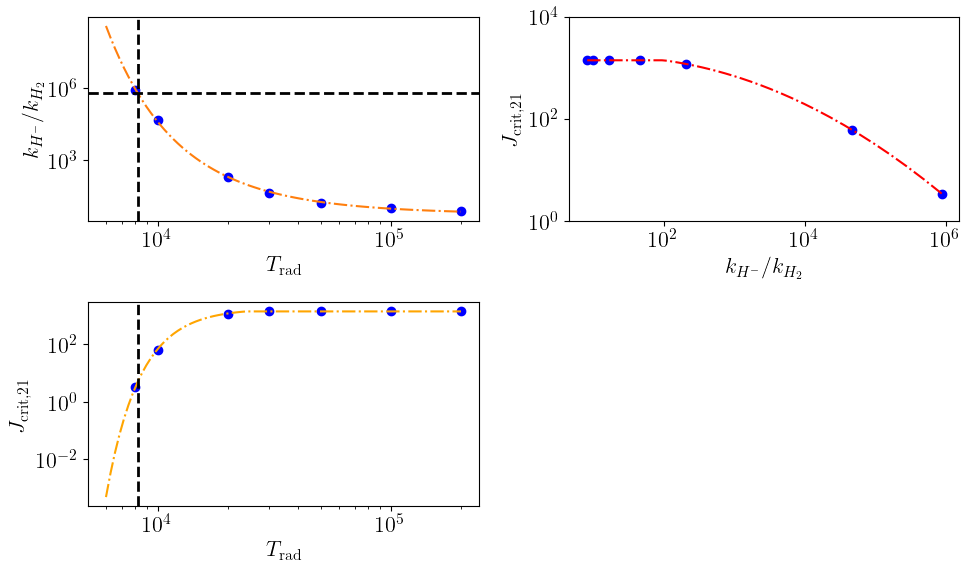

In [123]:
fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.scatter(Temp_range, k_ratio_range, c='blue')
# ax1.plot(Temp_detailed, 10**sigma_interpolation, c='red', ls='-.')
ax1.plot(Temp_extrapolated, 10**func_Temp_2_kratio(np.log10(Temp_extrapolated), *popt_kT), ls='-.', c='tab:orange')
ax1.axvline(x=T_Hm, ls='--', lw=2, c='black')
ax1.axhline(y=10**func_Temp_2_kratio(np.log10(T_Hm), *popt_kT), ls='--', lw=2, c='black')
ax1.set_xlabel(r'$T_{\rm rad}$')
ax1.set_ylabel('$k_{H^-}/k_{H_2}$')
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.scatter(k_ratio_range, J_crit_k_ratio(k_ratio_range), c='blue')
ax2.plot(10**sigma_interpolation, J_crit_k_ratio(10**sigma_interpolation), c='red', ls='-.')
ax2.set_ylabel(r'$J_{\rm crit, 21}$')
ax2.set_xlabel('$k_{H^-}/k_{H_2}$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1, 1e4)

ax3.scatter(Temp_range, J_crit_k_ratio(k_ratio_range), c='blue')
ax3.plot(Temp_extrapolated, J_crit_k_ratio(10**func_Temp_2_kratio(np.log10(Temp_extrapolated), *popt_kT)), c='orange', ls='-.')
ax3.axvline(x=T_Hm, ls='--', lw=2, c='black')
# ax3.axvline(x=HR_temperatures_high, ls='-', lw=1.5, c='red')
# ax3.axvline(x=HR_temperatures_low, ls='-', lw=1.5, c='red')

ax3.set_ylabel(r'$J_{\rm crit, 21}$')
ax3.set_xlabel(r'$T_{\rm rad}$')
ax3.set_yscale('log')
ax3.set_xscale('log')
# ax3.set_ylim(1, 1e4)


plt.tight_layout()
plt.show()

In [80]:
def J_crit_Temp(Temp):
    """
    Return the LW crit specific intensity for a given temperature
    """
    
    return J_crit_k_ratio(10**func_Temp_2_kratio(np.log10(Temp), *popt_kT))

In [81]:
def J_crit_MBH(Mbh, units='solar'):
    """
    Return the LW crit specific intensity for a given BH mass
    """    
    
    T_HR = Hawking_temperature_from_mass(Mbh, units=units)
    
    return J_crit_Temp(T_HR)

## Luminosity for DCBHs

Lyman-Werner background: $11.2-13.6$ eV or middle value $12.55$ eV. We choose the middle value for simplicity.

### 0. X-rays feedback constraints

X-rays can provide positive feedback to star formation, by enhancing production of $H_2$, and hence cooling. We find the BH masses where X-rays are stronger than LW, by calculating the ratio $B_{\rm LW}/B_{\rm X-rays}$, taking as X-rays value, photons with energy $1$ keV.

In [82]:
masses = 0.7*np.logspace(-14, -13, 50)

ratio = J_LW_single_BH(1, masses, E_eV=12.5, units='solar', f_eff=0.2, f_grey=0.24)/\
        J_LW_single_BH(1, masses, E_eV=1e3, units='solar', f_eff=0.2, f_grey=0.24)

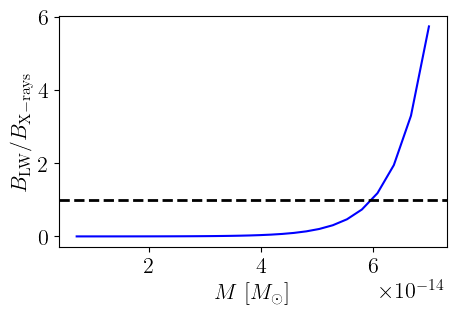

In [83]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(masses, ratio, c='blue', ls='-')

ax1.axhline(y=1, ls='--', lw=2, c='black')

ax1.set_ylabel(r'$B_{\rm LW}/B_{\rm X-rays}$')
ax1.set_xlabel('$M\ [M_\odot]$')

plt.show()

In [84]:
masses = 2.5*np.logspace(-14, -13, 50)

ratio_soft = J_LW_single_BH(1, masses, E_eV=12.5, units='solar', f_eff=0.2, f_grey=0.24)/\
        J_LW_single_BH(1, masses, E_eV=200, units='solar', f_eff=0.2, f_grey=0.24)

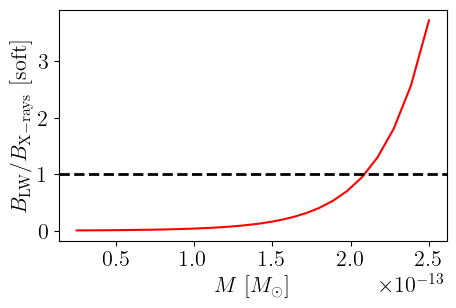

In [85]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(masses, ratio_soft, c='red', ls='-')

ax1.axhline(y=1, ls='--', lw=2, c='black')

ax1.set_ylabel(r'$B_{\rm LW}/B_{\rm X-rays}$ [soft]')
ax1.set_xlabel('$M\ [M_\odot]$')

plt.show()

A more realistic ratio, based on simulations [Figure 5 - [here](https://arxiv.org/pdf/2107.07883)], needs $B_{\rm LW}/B_{\rm X-rays} > 1000$, but also large $J_{\rm LW}$, i.e. above the critical value.

In [86]:
masses = 4*np.logspace(-14, -13, 200)

ratio = J_LW_single_BH(1, masses, E_eV=12.5, units='solar', f_eff=0.2, f_grey=0.24)/\
        J_LW_single_BH(1, masses, E_eV=1e3, units='solar', f_eff=0.2, f_grey=0.24)

ratio_soft = J_LW_single_BH(1, masses, E_eV=12.5, units='solar', f_eff=0.2, f_grey=0.24)/\
        J_LW_single_BH(1, masses, E_eV=200, units='solar', f_eff=0.2, f_grey=0.24)

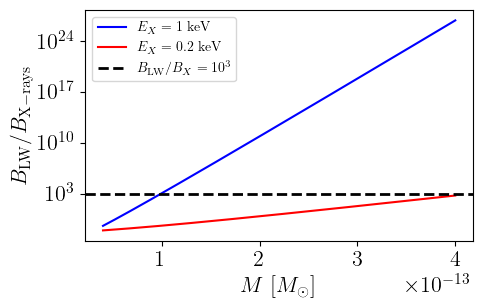

In [87]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(masses, ratio, c='blue', ls='-', label=r'$E_X = 1$ keV')
ax1.plot(masses, ratio_soft, c='red', ls='-', label=r'$E_X = 0.2$ keV')

# ax1.axhline(y=1, ls='--', lw=2, c='black')
ax1.axhline(y=1000, ls='--', lw=2, c='black', label=r'$B_{\rm LW}/B_X = 10^3$')

ax1.set_ylabel(r'$B_{\rm LW}/B_{\rm X-rays}$')
ax1.set_xlabel('$M\ [M_\odot]$')
ax1.set_yscale('log')
ax1.legend(fontsize=10)

plt.show()

<div class="alert alert-block alert-info">
<b>Constraints from X-rays feedback</b> 

We want $B_{\rm LW} \geq 1000 \cdot B_{\rm X-rays}$, which leads to masses bigger than:

- $M_{\rm BH} \geq  1 \cdot 10^{-13} M_\odot$, for strong X-rays.
- $M_{\rm BH} \geq  2 \cdot 10^{20}$ g, for strong X-rays. 
- $M_{\rm BH} \geq  4 \cdot 10^{-13} M_\odot$, for soft X-rays.
- $M_{\rm BH} \geq  8 \cdot 10^{20}$ g, for soft X-rays.    

For more massive PBH will emit at lower energies, so to overcome the soft X-rays we need to go to even larger masses, so that the peak blackbody spectrum to move further to lower energies.
    
</div>

## Mass Range limits

<div class="alert alert-block alert-info">
<b>Limits on minimum and maximum mass from X-rays feedback, and $T_{\rm crit}$ </b> 

- $4 \cdot 10^{-13} M_\odot \leq M_{\rm BH} \leq  7.5 \cdot 10^{-12} M_\odot$.
- $8 \cdot 10^{20}$ g $\leq M_{\rm BH} \leq  1.5 \cdot 10^{22}$ g.    
    
</div>

In [88]:
## BH mass limits in solar masses
M_BH_min = 4e-13
M_BH_max = 7.5e-12

### 1. Constant distance and monochromatic PBHs

We choose a distance range and mass range, and calculate the total number of PBHs of this mass needed or the total mass of the halo

In [89]:
distance_range = np.linspace(250, 500, 80)  # in parsec
masses_range = np.logspace(np.log10(M_BH_min), np.log10(M_BH_max), 50)  # in Mo

In [90]:
Dgrid_, Mgrid_ = np.meshgrid(distance_range, masses_range)

Calculate the specific intensity of a single BH at a given mass

In [91]:
J_LH_single = np.zeros_like(Dgrid_)

for idx_D, Dist in enumerate(distance_range):
    for idx_M, Mass in enumerate(masses_range):
        J_LH_single[idx_M, idx_D] = J_LW_single_BH(Dist, Mass)

We now calculate how many PBHs we would need to acchieve $J_{\rm crit} = f(M)$ and the total mass of their halo.

In [92]:
N_BH_min = J_crit_MBH(Mgrid_)/J_LH_single
Mass_BH_min = N_BH_min*Mgrid_

In [93]:
print(f"Min J_crit is: {round(np.min(J_crit_MBH(Mgrid_)), 2)}, and Max J_crit is: {round(np.max(J_crit_MBH(Mgrid_)), 2)}")

Min J_crit is: 5.12, and Max J_crit is: 1400.0


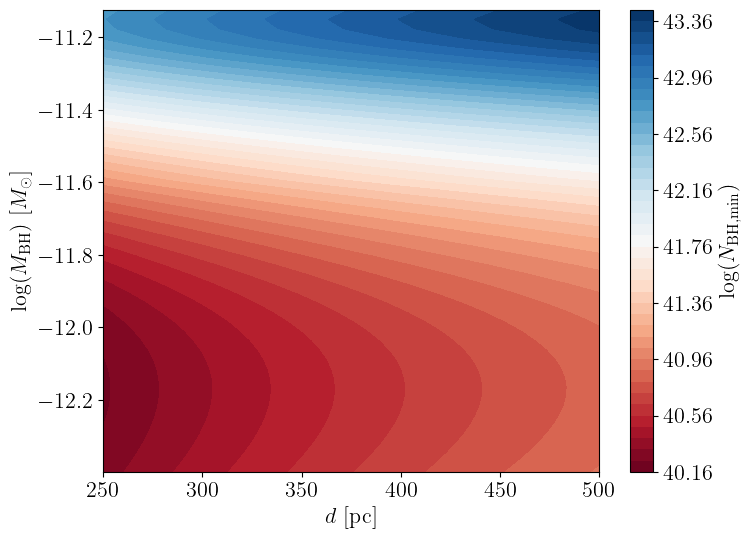

In [94]:
fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

cs = ax.contourf(Dgrid_, np.log10(Mgrid_), np.log10(N_BH_min), 45, cmap='RdBu')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'$\log(N_{\rm BH, min})$')

ax.set_xlabel(r"$d\ [{\rm pc}]$")
ax.set_ylabel(r"$\log(M_{\rm BH})\ [M_\odot]$")

# plt.show()
plt.savefig("Figures/Npbh_min_constant_D_monochromatic.png", bbox_inches='tight')

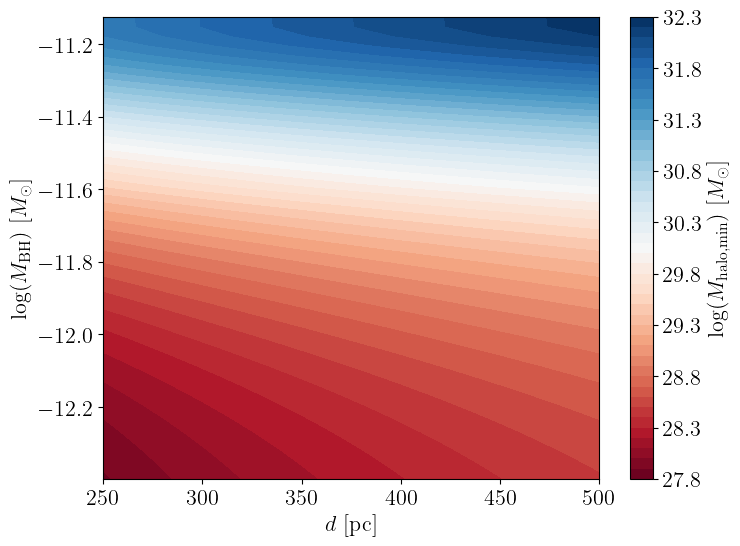

In [95]:
fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

cs = ax.contourf(Dgrid_, np.log10(Mgrid_), np.log10(Mass_BH_min), 45, cmap='RdBu')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'$\log(M_{\rm halo, min})\ [M_\odot]$')

ax.set_xlabel(r"$d\ [{\rm pc}]$")
ax.set_ylabel(r"$\log(M_{\rm BH})\ [M_\odot]$")

# plt.show()
plt.savefig("Figures/Mpbh_halo_min_constant_D_monochromatic.png", bbox_inches='tight')

### 2. LW background and monochromatic PBHs

We calculate:

$$
J_{\rm LW, 21}^{\rm bg} \sim 10^{21} \frac{c R_{\rm S}^2 B_{\rm LW}}{M_{\rm BH}} f_{\rm PBH} \Omega_{m, 0} \frac{3 H_0^2}{8 G} (1+z)^3 \frac{f-1}{H(z)}
$$

for $z=10$ and $M=10^{-12} \ M_\odot$.

In [98]:
## At LW band
LW_background(M_BH_max, 10, f_z=1.04), LW_background(M_BH_min, 10, f_z=1.04)

(4.2671023307932404e-26, 6.701267766598889e-20)

In [99]:
## At H- dissociation band
LW_background(M_BH_max, 10, E_eV=2.0, f_z=1.04), LW_background(M_BH_min, 10, E_eV=2.0, f_z=1.04)

(5.080654156369057e-22, 2.639631609954914e-21)

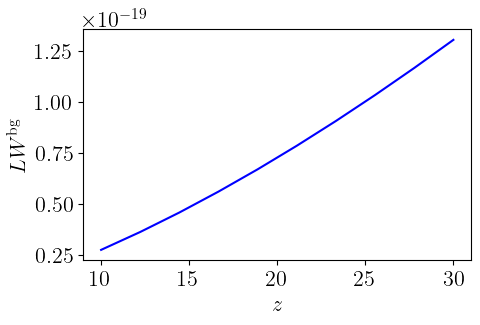

In [196]:
redshifts = np.linspace(10, 30, 10)

fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshifts, LW_background(1e-12, redshifts, f_z=1.04), c='blue', ls='-')

ax1.set_ylabel(r'$LW^{\rm bg}$')
ax1.set_xlabel('$z$')

plt.show()

*Checking the effects of small $\Delta z$ approximation*, which would be equivalent to a "flat, blackbody spectrum".

In [102]:
z = 10
zmax = z + (1.04-1)*(1+z)

print(z, zmax)

10 10.440000000000001


Approximation for small $\Delta z$ (this would give the more optimistic case):

In [103]:
Spectrum_freq_mass(nu_Hm, M_BH_min)*(1.04-1)*(1+z)

2.16699248847841e-07

Integrating the spectrum (in this part we do not approximate the integral, but do a numerical integration):

In [104]:
z_grid = np.linspace(z, zmax, 100)

In [105]:
np.trapz(Spectrum_freq_mass(photons_from_energy(2.0)[0]*z_grid/(1+z), M_BH_min), z_grid)

1.8810740735500117e-07

### 3. PBH densities and monochromatic PBHs

We now consider the PBHs living inside our halo, and calculate their radiation as a background at the centre of the halo. 

We choose a reference redshift of $z=15$ and vary the halo mass, within the allowed range to find $r_{\rm max}$ as the virial radius. 

We investigate two distributions of PBHs - uniform and isothermal. And investigate cases of different fixed density.

In [106]:
## Choose halo mass ranges
Mass_halo = np.logspace(6, 12, 10)

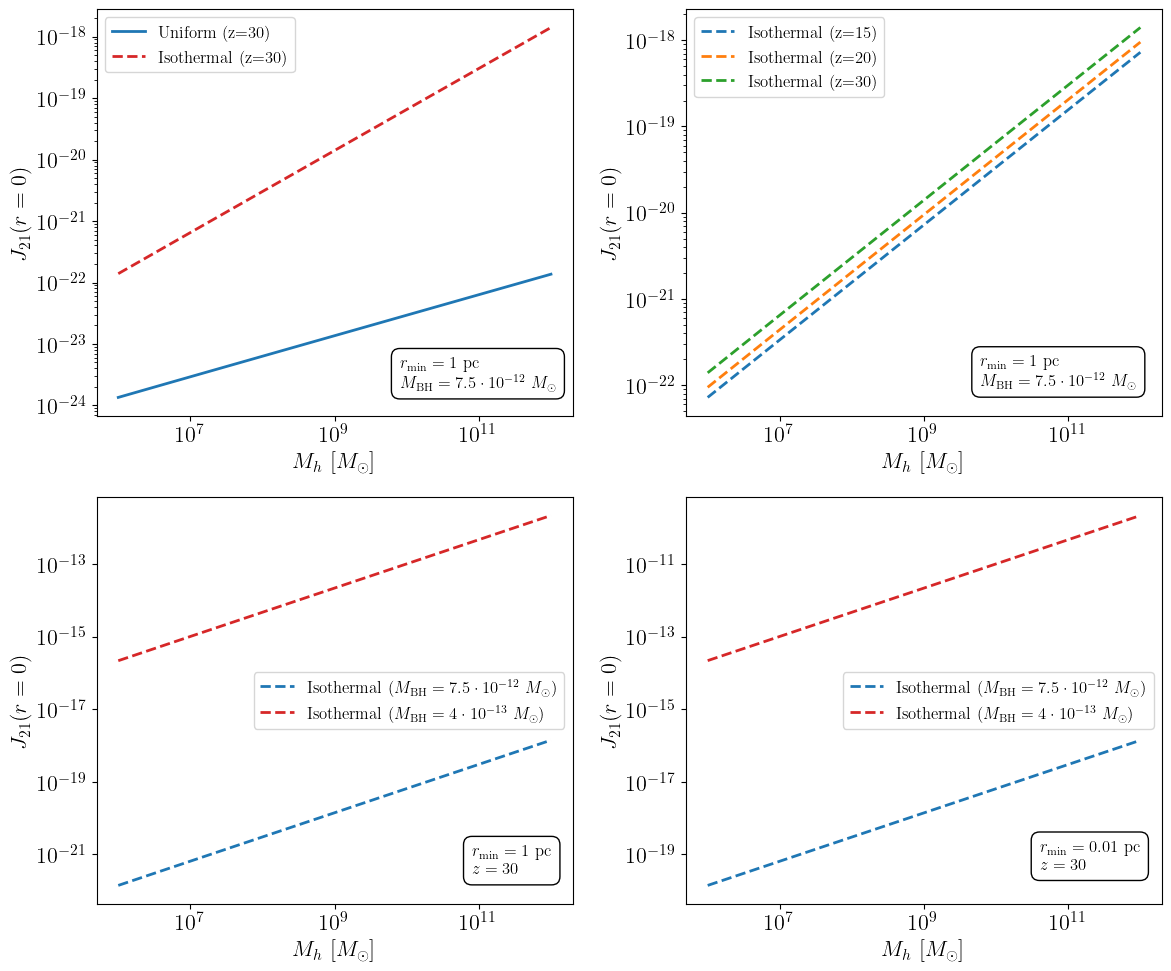

In [107]:
fig= plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=30, rmin=1, method='uniform'),\
           label='Uniform (z=30)', ls='-', lw=2, c='tab:blue')
ax1.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=30, rmin=1), label='Isothermal (z=30)',\
           ls='--', lw=2, c='tab:red')

text = r'$r_{\rm min} = 1\ {\rm pc}$' '\n' r'$M_{\rm BH}=7.5 \cdot 10^{-12}\ M_\odot$'
ax1.text(8e9, 2e-24, text, fontsize=12,\
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))
ax1.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax1.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax1.legend(fontsize=12)


ax2.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=15, rmin=1), label='Isothermal (z=15)', ls='--', lw=2)
ax2.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=20, rmin=1), label='Isothermal (z=20)', ls='--', lw=2)
ax2.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=30, rmin=1), label='Isothermal (z=30)', ls='--', lw=2)

text = r'$r_{\rm min} = 1\ {\rm pc}$' '\n' r'$M_{\rm BH}=7.5 \cdot 10^{-12}\ M_\odot$'
ax2.text(6e9, 1e-22, text, fontsize=12,\
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))
ax2.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax2.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax2.legend(fontsize=12)



ax3.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=30, rmin=1),\
           label=r'Isothermal ($M_{\rm BH}=7.5 \cdot 10^{-12}\ M_\odot$)', ls='--', lw=2, c='tab:blue')
ax3.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1),\
           label=r'Isothermal ($M_{\rm BH}=4 \cdot 10^{-13}\ M_\odot$)', ls='--', lw=2, c='tab:red')

text = r'$r_{\rm min} = 1\ {\rm pc}$' '\n' r'$z=30$'
ax3.text(8e10, 3e-22, text, fontsize=12,\
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))
ax3.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax3.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax3.legend(fontsize=12)



ax4.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_max, z=30, rmin=1e-2),\
           label=r'Isothermal ($M_{\rm BH}=7.5 \cdot 10^{-12}\ M_\odot$)', ls='--', lw=2, c='tab:blue')
ax4.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1e-2),\
           label=r'Isothermal ($M_{\rm BH}=4 \cdot 10^{-13}\ M_\odot$)', ls='--', lw=2, c='tab:red')

text = r'$r_{\rm min} = 0.01\ {\rm pc}$' '\n' r'$z=30$'
ax4.text(4e10, 4e-20, text, fontsize=12,\
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))
ax4.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax4.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax4.legend(fontsize=12)


plt.tight_layout()
# plt.show()
plt.savefig("Figures/Jcrit_Density_monochromatic.png", bbox_inches='tight')

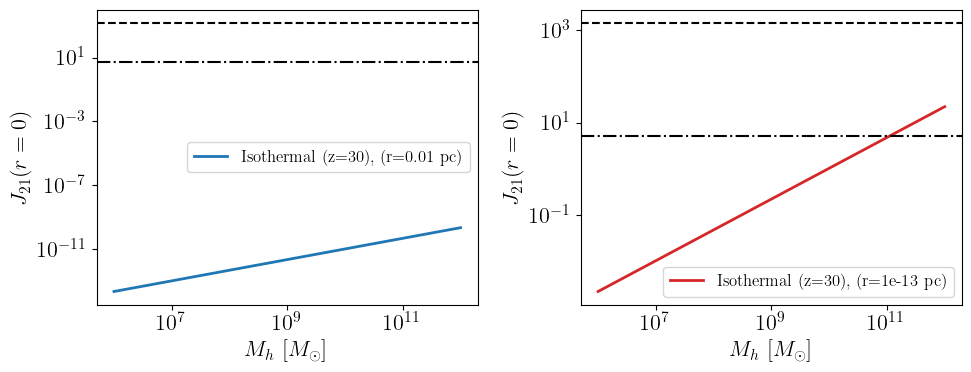

In [120]:
## LW range

fig= plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1e-2), label='Isothermal (z=30), (r=0.01 pc)',\
           ls='-', lw=2, c='tab:blue')
ax1.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax1.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax1.legend(fontsize=12)
ax1.axhline(y=np.max(J_crit_MBH(Mgrid_)), ls='--', c='black')
ax1.axhline(y=np.min(J_crit_MBH(Mgrid_)), ls='-.', c='black')

ax2.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1e-13), label='Isothermal (z=30), (r=1e-13 pc)',\
           ls='-', lw=2, c='tab:red')
ax2.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax2.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax2.legend(fontsize=12)

ax2.axhline(y=np.max(J_crit_MBH(Mgrid_)), ls='--', c='black')
ax2.axhline(y=np.min(J_crit_MBH(Mgrid_)), ls='-.', c='black')


plt.tight_layout()
plt.show()

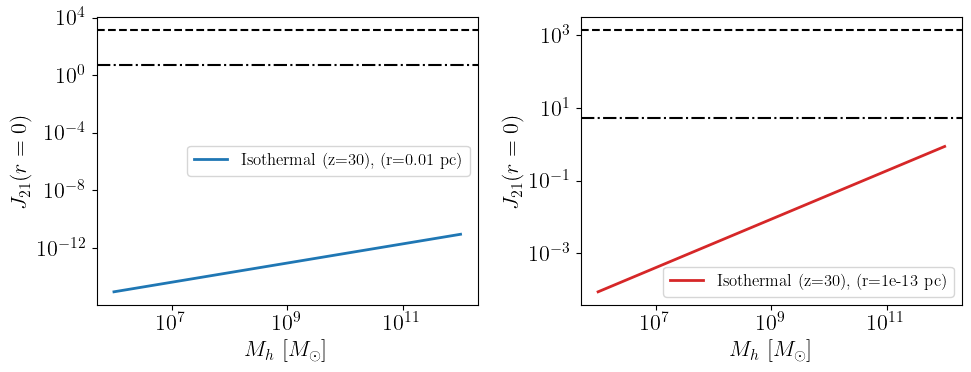

In [122]:
## H- diss range

fig= plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1e-2, E_eV=2.0), label='Isothermal (z=30), (r=0.01 pc)',\
           ls='-', lw=2, c='tab:blue')
ax1.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax1.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax1.legend(fontsize=12)
ax1.axhline(y=np.max(J_crit_MBH(Mgrid_)), ls='--', c='black')
ax1.axhline(y=np.min(J_crit_MBH(Mgrid_)), ls='-.', c='black')

ax2.loglog(Mass_halo, J_LW_critical_density(Mass_halo, Mbh=M_BH_min, z=30, rmin=1e-13, E_eV=2.0), label='Isothermal (z=30), (r=1e-13 pc)',\
           ls='-', lw=2, c='tab:red')
ax2.set_xlabel(r"$M_{h}\ [M_\odot]$")
ax2.set_ylabel(r"$J_{\rm 21}(r=0)$")
ax2.legend(fontsize=12)

ax2.axhline(y=np.max(J_crit_MBH(Mgrid_)), ls='--', c='black')
ax2.axhline(y=np.min(J_crit_MBH(Mgrid_)), ls='-.', c='black')


plt.tight_layout()
plt.show()

In [85]:
print(f'The minimum radius required for to surpass Jcrit is rmin {1e-13} pc, or {1e-13*PARSEC_2_M} m.')

The minimum radius required for to surpass Jcrit is rmin 1e-13 pc, or 3100.0 m.


In [86]:
print(f'The Schwarzschild_radius for a BH of mass 1e5 is {Schwarzschild_radius(1e5)} m, \
or {Schwarzschild_radius(1e5)/PARSEC_2_M} pc.')

The Schwarzschild_radius for a BH of mass 1e5 is 295561178.7109229 m, or 9.534231571320094e-09 pc.


-----------------------------------------------------

# Primordial Black Holes Mass Functions <a name="PBH_masses"></a>

Primordial BHs can form when overdensities collapse in the early Universe. PBHs at formation time can have a range of masses, and a distribution that is very much dependent on the model. Useful link for more details [[here](https://arxiv.org/pdf/2402.03934.pdf)].

Here we study a:

- Lognormal mass function
- Power-law mass function
- Broken Power-law mass function
- Critical Collapse mass function

We initially reproduce the [[figure](https://arxiv.org/pdf/2402.03934#page=4&zoom=auto,-265,740)] from the paper above. This means that we use a different mass range than what we expect for our scenario.

Return to TOC [here](#toc).

__1. Lognormal Mass Function__

In [87]:
pbh_mass_range = np.linspace(0.05, 20, 100)
lognormal_mass_function = lognormal_PBH_mass_function(pbh_mass_range, 50, 2)

In [88]:
masses_randoms = np.random.uniform(0.05, 20, size=5000)
weights = lognormal_PBH_mass_function(masses_randoms, 50, 2)/np.sum(lognormal_PBH_mass_function(masses_randoms, 50, 2))
random_masses_lognormal = np.random.choice(masses_randoms, replace=True, size=4000, p=weights)

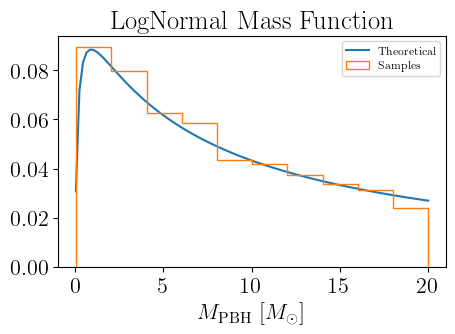

In [89]:
fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)

ax1.plot(pbh_mass_range, lognormal_mass_function*3,\
        label = "Theoretical")

ax1.hist(random_masses_lognormal, density=True, histtype='step',\
        label = "Samples")

ax1.set_title('LogNormal Mass Function')
ax1.set_xlabel(r'$M_{\rm PBH}\ [M_{\odot}]$')
ax1.legend(fontsize=8)

plt.show()

__2. Power-law Mass Function__

In [90]:
PBH_mass_range = np.linspace(5, 20, 100)
power_law_mass_function = power_law_PBH_mass_function(PBH_mass_range, 10, 2)

In [91]:
random_masses = np.random.uniform(5, 20, size = 5000)
weights = power_law_PBH_mass_function(random_masses, 10, 2)/np.sum(power_law_PBH_mass_function(random_masses, 10, 2))
random_masses_power_law = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

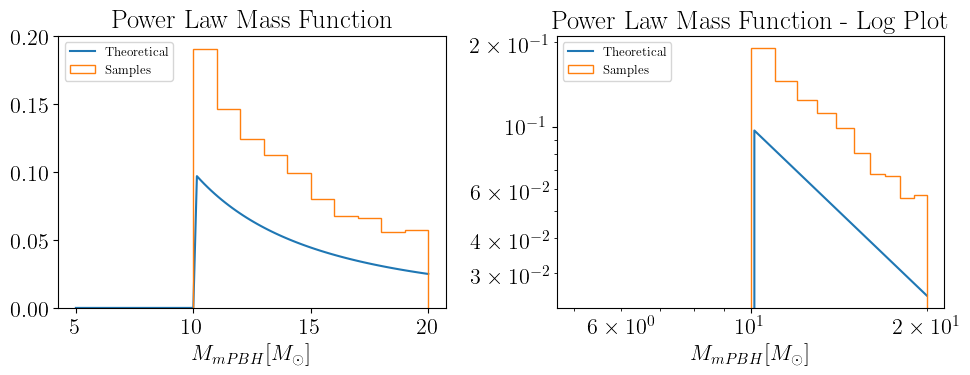

In [92]:
fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(PBH_mass_range, power_law_mass_function, label = 'Theoretical')
ax1.hist(random_masses_power_law, density = True, histtype = 'step', label = 'Samples')
ax1.set_title('Power Law Mass Function')
ax1.set_xlabel('$M_{\rm PBH} [M_{\odot}]$')
ax1.legend(fontsize = 9)

ax2.loglog(PBH_mass_range, power_law_mass_function, label = 'Theoretical')
ax2.hist(random_masses_power_law, density = True, histtype = 'step', label = 'Samples')
ax2.set_xlabel('$M_{\rm PBH} [M_{\odot}]$')
ax2.set_title('Log Plot')
ax2.set_title('Power Law Mass Function - Log Plot')
ax2.legend(fontsize = 9)


plt.tight_layout()
plt.show()

__3. Broken Power-law Mass Function__

In [93]:
PBH_mass_range = np.linspace(0.05, 20, 100)
broken_pl_mass_function = broken_pl_PBH_mass_function(PBH_mass_range, 10, 1, 2)

In [94]:
random_masses = np.random.uniform(0.05, 20, size = 5000)
weights = broken_pl_PBH_mass_function(random_masses, 10, 1, 2)/np.sum(broken_pl_PBH_mass_function(random_masses, 10, 1, 2))
random_masses_broken_pl = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

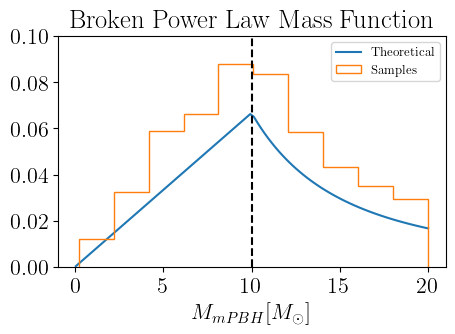

In [95]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(PBH_mass_range, broken_pl_mass_function, label = 'Theoretical')
ax1.hist(random_masses_broken_pl, density = True, histtype = 'step', label = 'Samples')

ax1.set_xlabel('$M_{\rm PBH} [M_{\odot}]$')
ax1.set_title('Broken Power Law Mass Function')
ax1.legend(fontsize = 9)
ax1.set_ylim([0, 0.1])

ax1.axvline(x = 10, color = 'black', linestyle = '--')

plt.show()

__4. Critical Collapse Mass Function__

In [96]:
PBH_mass_range = np.linspace(0.05, 20, 100)
crit_collapse_mass_function = crit_collapse_PBH_mass_function(PBH_mass_range, 10, 1.5)

In [97]:
random_masses = np.random.uniform(0.05, 20, size = 5000)
weights = crit_collapse_PBH_mass_function(random_masses, 10, 1.5)/np.sum(crit_collapse_PBH_mass_function(random_masses, 10, 1.5))
random_masses_crit_collapse = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

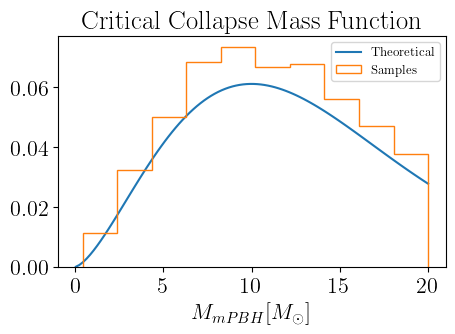

In [98]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(PBH_mass_range, crit_collapse_mass_function, label = 'Theoretical')
ax1.hist(random_masses_crit_collapse, density = True, histtype = 'step', label = 'Samples')

ax1.set_xlabel('$M_{\rm PBH} [M_{\odot}]$')
ax1.set_title('Critical Collapse Mass Function')
ax1.legend(fontsize = 9)

plt.show()

### Comparison of PBH mass functions

In [99]:
PBH_mass_range = np.linspace(1, 100, 200)
lognormal_mass_function = normalise(lognormal_PBH_mass_function(PBH_mass_range, 30, 1))
power_law_mass_function = normalise(power_law_PBH_mass_function(PBH_mass_range, 8, 1.5))
broken_pl_mass_function = normalise(broken_pl_PBH_mass_function(PBH_mass_range, 30, 0.2, 2))
crit_collapse_mass_function = normalise(crit_collapse_PBH_mass_function(PBH_mass_range, 20, 1))

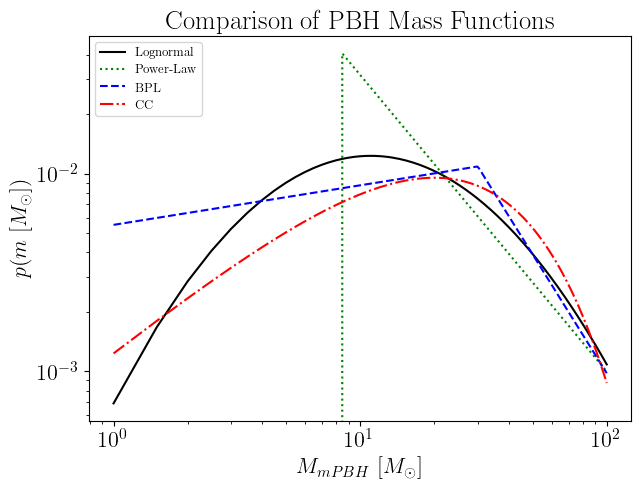

In [100]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(PBH_mass_range, lognormal_mass_function, label = 'Lognormal', c='black')
ax1.loglog(PBH_mass_range, power_law_mass_function, label = 'Power-Law', c='green', ls=':')
ax1.loglog(PBH_mass_range, broken_pl_mass_function, label = 'BPL', c='blue', ls='--')
ax1.loglog(PBH_mass_range, crit_collapse_mass_function, label = 'CC', c='red', ls='-.')

ax1.set_ylabel('$p(m\ [M_{\odot}])$')
ax1.set_xlabel('$M_{\rm PBH}\ [M_{\odot}]$')
ax1.set_title('Comparison of PBH Mass Functions')
ax1.legend(fontsize = 9, loc='upper left')


plt.show()

### Total blackbody spectrum from random masses selected from the different mass functions

In [101]:
frequencies = np.linspace(1, 1e7, 1000)

blackbody_spectrum_ln = total_blackbody_spectrum(frequencies, random_masses_lognormal)
blackbody_spectrum_pl = total_blackbody_spectrum(frequencies, random_masses_power_law)
blackbody_spectrum_pbl = total_blackbody_spectrum(frequencies, random_masses_broken_pl)
blackbody_spectrum_cc = total_blackbody_spectrum(frequencies, random_masses_crit_collapse)

C:\Users\klera\Documents\GitHub\DCBHs_HR_PBHs\support.py:189: RuntimeWarning: overflow encountered in exp
  exp_denominator = np.exp(h*nu/(k*Temp))-1
C:\Users\klera\Documents\GitHub\DCBHs_HR_PBHs\support.py:190: RuntimeWarning: overflow encountered in multiply
  return f_grey*f_eff*2*h*nu**3/(c**2*exp_denominator)


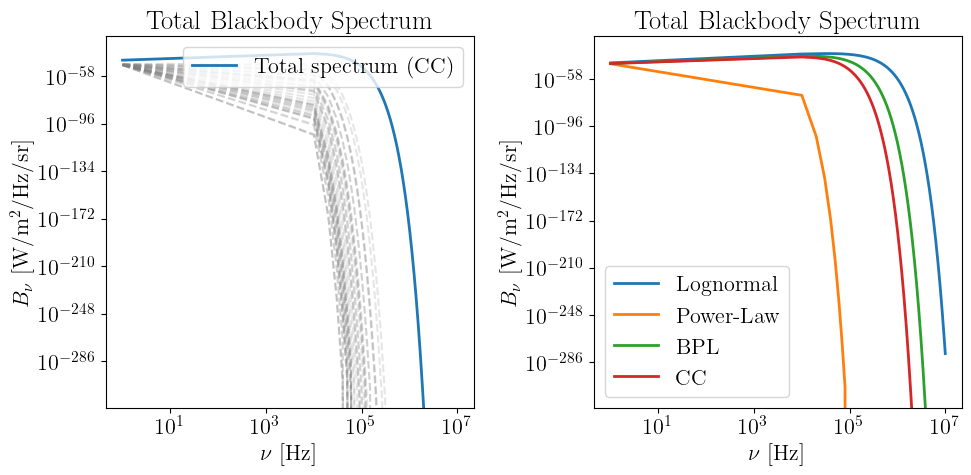

In [102]:
fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

for mass in random_masses_crit_collapse[::100]:
    ax1.loglog(frequencies, Spectrum_freq_mass(frequencies, mass), c='grey', ls='--', alpha=0.2)
        
ax1.loglog(frequencies, blackbody_spectrum_cc, label='Total spectrum (CC)', lw=2)
ax1.set_xlabel(r'$\nu$ [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Total Blackbody Spectrum')
ax1.legend()


ax2.loglog(frequencies, blackbody_spectrum_ln, label='Lognormal', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_pl, label='Power-Law', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_pbl, label='BPL', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_cc, label='CC', lw=2)

ax2.set_xlabel(r'$\nu$ [Hz]')
ax2.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax2.set_title('Total Blackbody Spectrum')
ax2.legend()


plt.tight_layout()
plt.show()

## Studying the $B_{\rm LW} R_S^2$ factor

The product of the specific intensity with the squared Schwarzschild radius plays an important role on the $J_{21}$ value. We investigate it here for different masses and compare with the mean value for a PBH mass function, i.e.

$$
\left< B_{\rm LW} R_S^2 \right> = \int_{M_{\rm min}}^{M_{\rm max}} B_{\rm LW} R_S^2 p(m) dm.
$$

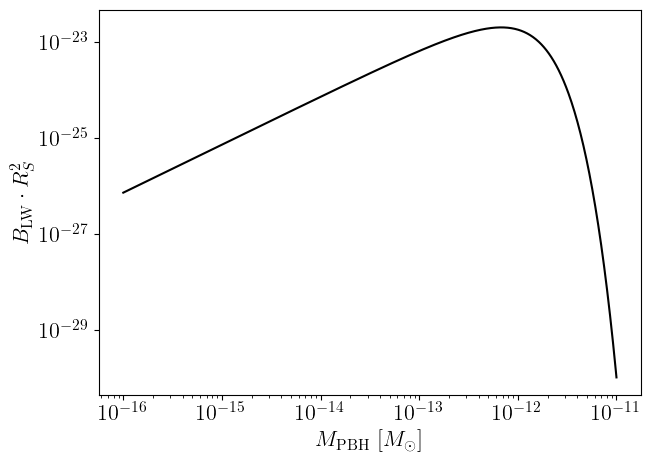

In [103]:
mass_range = np.logspace(-16, -11, 1000)

fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(mass_range, LW_Bv_RS(mass_range), c='black')

ax1.set_ylabel(r'$B_{\rm LW} \cdot R_S^2$')
ax1.set_xlabel(r'$M_{\rm PBH}\ [M_{\odot}]$')

plt.show()

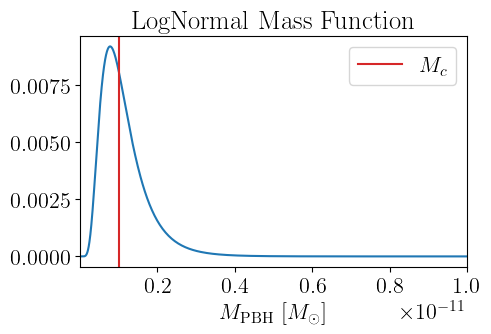

In [106]:
Mc = 1e-12
lognormal_mass_function = lognormal_PBH_mass_function(mass_range, Mc, 0.5)

fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)

ax1.plot(mass_range, normalise(lognormal_mass_function))
ax1.axvline(x=Mc, ls='-', c='tab:red', label=r'$M_c$')

ax1.set_title('LogNormal Mass Function')
ax1.set_xlabel(r'$M_{\rm PBH}\ [M_{\odot}]$')
ax1.legend()

ax1.set_xlim(1e-16, 1e-11)

plt.show()

In [107]:
## Same way of calculating the average value

LW_Bv_RS_mean = np.trapz(normalise(lognormal_mass_function)*LW_Bv_RS(mass_range))

LW_Bv_RS_mean = np.trapz(lognormal_mass_function*LW_Bv_RS(mass_range), x=mass_range)

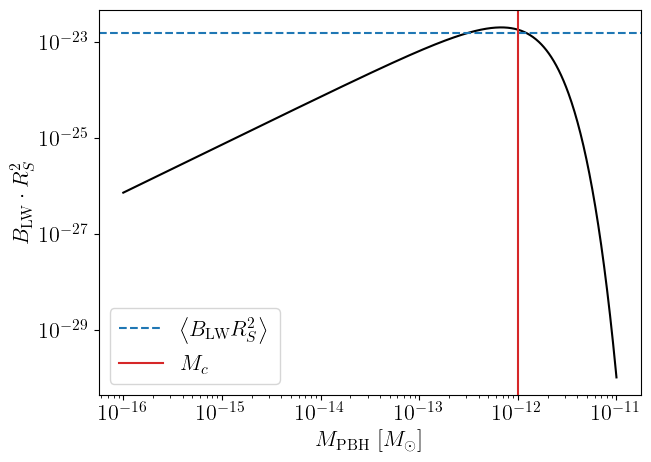

In [108]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(mass_range, LW_Bv_RS(mass_range), c='black')
ax1.axhline(y=LW_Bv_RS_mean, ls='--', c='tab:blue', label=r'$\left< B_{\rm LW} R_S^2 \right>$')
ax1.axvline(x=Mc, ls='-', c='tab:red', label=r'$M_c$')

ax1.set_ylabel(r'$B_{\rm LW} \cdot R_S^2$')
ax1.set_xlabel(r'$M_{\rm PBH}\ [M_{\odot}]$')
ax1.legend()

# plt.show()
plt.savefig("Figures/pbh_mass_function_effects.png", bbox_inches='tight')

------------------------

# Appendix <a name="appendix"></a>

Return to TOC [here](#toc).

## A.1 - Integrating the blackbody spectrum

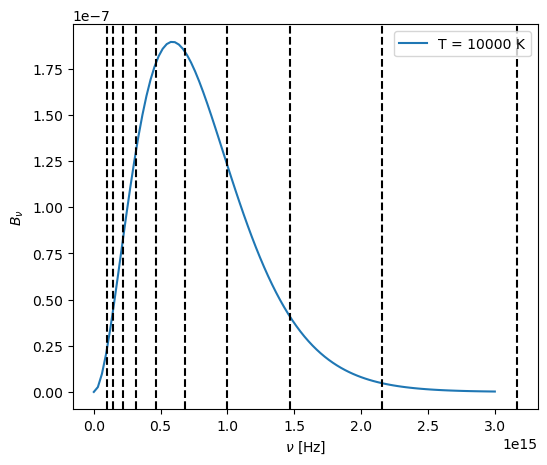

In [46]:
Radius = 20
Temp = 10000

frequencies = np.linspace(1, 3e15, 100)
max_frequencies = np.logspace(14, 15.5, 10)

fig= plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

ax.plot(frequencies, Spectrum_freq_temperature(frequencies, Temp), label = f"T = {Temp} K")

for max_nu in max_frequencies:
    ax.axvline(x=max_nu, ls='--', c='black')

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$")

plt.legend()
plt.show()

In [47]:
v_min = 1

integral_lum_quad = np.zeros_like(max_frequencies)
integral_lum_simpson = np.zeros_like(max_frequencies)

for i, freq in enumerate(max_frequencies):
    integral_lum_quad[i] = 4*pi**2*Radius**2*quad(Spectrum_freq_temperature, v_min, freq, args=(Temp))[0]
    frequencies = np.linspace(v_min, freq, 100)
    integral_lum_simpson[i] = 4*pi**2*Radius**2*simpson(Spectrum_freq_temperature(frequencies, Temp), frequencies)

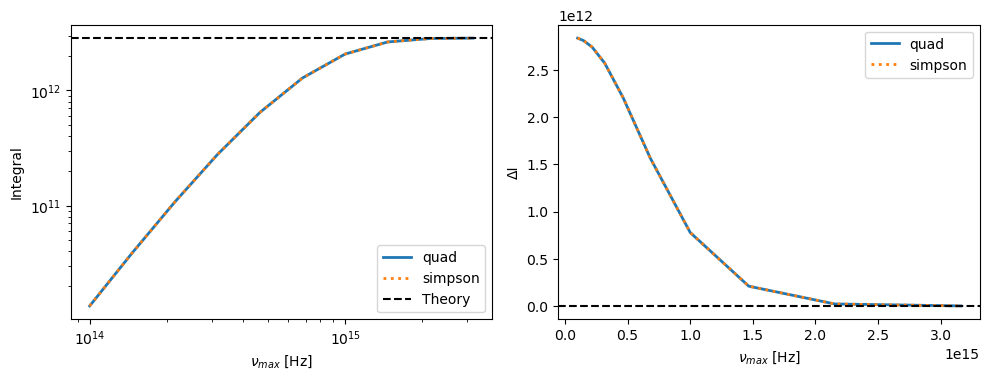

In [49]:
fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.loglog(max_frequencies, integral_lum_quad, label='quad', lw=2)
ax1.loglog(max_frequencies, integral_lum_simpson, label='simpson', lw=2, ls=':')
ax1.axhline(y = theoretical_lum(Radius, Temp), color = 'black', linestyle = '--', label='Theory')
ax1.set_xlabel('$ν_{max}$ [Hz]')
ax1.set_ylabel('Integral')
ax1.legend()

ax2.plot(max_frequencies, theoretical_lum(Radius, Temp) - integral_lum_quad, label='quad', lw=2)
ax2.plot(max_frequencies, theoretical_lum(Radius, Temp) - integral_lum_simpson, label='simpson', lw=2, ls=':')
ax2.axhline(y = 0, color = 'black', linestyle = '--')
ax2.set_xlabel('$ν_{max}$ [Hz]')
ax2.set_ylabel('ΔI')
ax2.legend()

plt.tight_layout()
plt.show()

__Integrating at a specific frequency range__

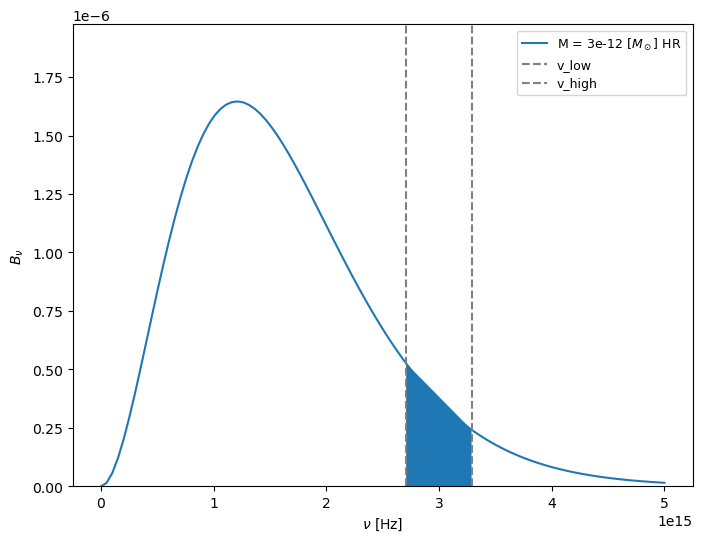

In [94]:
frequencies = np.linspace(1, 5e15, 100)

fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(frequencies, Spectrum_freq_mass(frequencies, 3e-12), label = r"M = 3e-12 [$M_\odot$] HR")
ax.fill_between([nu_low, nu_high], [Spectrum_freq_mass(nu_low, 3e-12), Spectrum_freq_mass(nu_high, 3e-12)], 0)
ax.axvline(x=nu_low, label='v_low', ls='--', c='grey')
ax.axvline(x=nu_high, label='v_high', ls='--', c='grey')

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$")
ax.set_ylim(0, 1.2*np.max(Spectrum_freq_mass(frequencies, 3e-12)))

plt.legend(fontsize=9)
plt.show()

In [44]:
# Integral in frequency range of interest
freq_range = np.linspace(nu_low, nu_high, 400)
simpson(Spectrum_freq_mass(freq_range, 3e-12), freq_range)

214450022.16161394

In [45]:
simpson(Spectrum_freq_mass(freq_range, 3e-12), freq_range)/simpson(Spectrum_freq_mass(frequencies, 3e-12), frequencies)*100

6.67877051964956

In [46]:
Spectrum_freq_mass(nu_low, 3e-12), Spectrum_freq_mass(nu_high, 3e-12)

(5.259704990159456e-07, 2.425694182453482e-07)